In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import os
from tqdm import tqdm
from glob import glob

from dataloader.handhygiene import HandHygiene
from spatial_transforms import Compose
from spatial_transforms import Normalize
from spatial_transforms import Scale
from spatial_transforms import CenterCrop
from spatial_transforms import ToTensor
from temporal_transforms import LoopPadding
from temporal_transforms import TemporalRandomCrop
from openpose_transforms import MultiScaleTorsoRandomCrop
from model.i3dpt import I3D, Unit3Dpy
from train import get_models
# from model.i3d import I3D_binary

from sklearn.metrics import confusion_matrix
os.environ["CUDA_VISIBLE_DEVICES"]='2'

In [9]:
import easydict
import random
import torch.backends.cudnn as cudnn

# len_clip, batch, step, lr, w_decay, epoch, start_epoch = 16, 384, 3, 1e-4, 1e-7, 100, 0 #20200404_iclr_softmax/
# len_clip, batch, step, lr, w_decay, epoch, start_epoch = 16, 256, 3, 1e-2, 1e-3, 100, 0 #20200720
args = easydict.EasyDict({"workers": 4, 
                          "epochs": 100, 
                          "start_epoch": 0,
                          "clip_len": 16,
                          "batch_size": 1,
                          "lr": 1e-3,
                          "momentum": 0.9,
                          "weight_decay": 1e-4,
                          "world_size": 1,
                          "rank": 1,
                          "seed": 100,
                          "gpu": None,
                          "dist_backend": "nccl",
                          "multiprocessing": True,
                          "multiprocessing_distributed": False
                         })

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [14]:
#batch, step, lr, w_decay, epoch = 1, 16, 1e-2, 1e-4, 50 #, scheduler
batch, len_clip, step = 1, 16, 16

VIDEO_DIR='./data/images_new' #./data/videos
#STEPS = {key: step for key in classes}

STEPS = {'touching_equipment': 1,
        'rubbing_hands': 1,
#         'wearing_gloves': 1,
        'other_action': 3}
IMG_SIZE = 224
MEAN = [110.2008, 100.63983, 95.99475] # [110.63666788, 103.16065604, 96.29023126]
STD = [58.14765, 56.46975, 55.332195] # [38.7568578, 37.88248729, 40.02898126]

scales = np.linspace(0.8, 1.2, num=1000)
center = 1


# center*=2
openpose_transform = {
    'test':MultiScaleTorsoRandomCrop(np.linspace(center, center, num=1), 
                                    IMG_SIZE, centercrop=True)
}

spatial_transform = {
    'test': Compose([Scale(IMG_SIZE), 
                    CenterCrop(IMG_SIZE), 
                    ToTensor(1), 
                    Normalize(MEAN, STD)])}

temporal_transform = {'test':LoopPadding(args.clip_len)}


dataset = {
    'test': HandHygiene(os.path.join(VIDEO_DIR, 'test'), 
                        frames_per_clip=args.clip_len,
                        step_between_clips=STEPS,
                        temporal_transform=temporal_transform['test'],
                        openpose_transform=openpose_transform['test'],
                        spatial_transform=spatial_transform['test']
                       )
}

num_classes = len(dataset['test'].classes)

dataloaders = {
    'test': DataLoader(dataset['test'], batch_size=args.batch_size, shuffle=False, num_workers=args.workers)
}

Training for classes rubbing_hands, touching_equipment, other_action


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Number of ./data/images_new/test video clips: 1552 (1798 images)
Number of clips:  {'rubbing_hands': 517, 'touching_equipment': 487, 'other_action': 548}
Number of frames:  {'rubbing_hands': 1111, 'touching_equipment': 757, 'other_action': 3003}
Total number of frames: {'rubbing_hands': 19818, 'touching_equipment': 32918, 'other_action': 27008}


In [15]:
from train import change_key

rgb_weights_path = 'weights/i3d/20200803/handhygiene_i3d_rgb_bestiters_joint_1292.pth'
flow_weights_path = 'weights/i3d/20200803/handhygiene_i3d_flow_bestiters_joint_1292.pth'

def change_key(ordereddict):
    statedict = ordereddict.copy()
    for i, key in enumerate(ordereddict.keys()):
        key, value = statedict.popitem(False)
        old = key
        statedict[key.replace('module.', '') if key == old else key] = value
    return statedict

def modify_last_layer(out_channels):
    #last_layer
    conv2 = Unit3Dpy(in_channels=400,
                     out_channels=out_channels, 
                     kernel_size=(1, 1, 1),
                     activation=None, 
                     use_bias=True, use_bn=False)
    return conv2
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

i3d_rgb = I3D(num_classes=400, modality='rgb', dropout_prob=0.5)
i3d_rgb.conv3d_0c_1x1 = torch.nn.Sequential(i3d_rgb.conv3d_0c_1x1, modify_last_layer(num_classes))
statedict = change_key(torch.load(rgb_weights_path))
i3d_rgb.load_state_dict(statedict)

i3d_flow = I3D(num_classes=400, modality='flow', dropout_prob=0.5)
i3d_flow.conv3d_0c_1x1 = torch.nn.Sequential(i3d_flow.conv3d_0c_1x1, modify_last_layer(num_classes))
statedict = change_key(torch.load(flow_weights_path))
i3d_flow.load_state_dict(statedict)

i3d_flow.to(device)

I3D(
  (conv3d_1a_7x7): Unit3Dpy(
    (pad): ConstantPad3d(padding=(2, 3, 2, 3, 2, 3), value=0)
    (conv3d): Conv3d(2, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), bias=False)
    (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxPool3d_2a_3x3): MaxPool3dTFPadding(
    (pad): ConstantPad3d(padding=(0, 1, 0, 1, 0, 0), value=0)
    (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=True)
  )
  (conv3d_2b_1x1): Unit3Dpy(
    (conv3d): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3d_2c_3x3): Unit3Dpy(
    (conv3d): Conv3d(64, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (batch3d): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxPool3d_3a_3x3): MaxPool3dTFPadding(
    (pad): ConstantPad3d(paddin

In [16]:
#y_test= dataset['test'].samples[2]
y_test=[]
y_pred=[]
y_pred_rgb=[]
y_pred_flow=[]


def run_demo(item, path, corrects):
    #classes_path = 'data/label_map.txt'
    kinetics_classes = dataset['test'].classes #[x.strip() for x in open(classes_path)]
    top_k = 1
    basename = os.path.basename(path)
    
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    label = item[2]
    shape = np.asarray(flows[0]).shape
    images = []
    optflows = []
    
    def get_scores(sample, model):
        sample_var = torch.autograd.Variable(torch.from_numpy(sample).cuda())
        out_var, out_logit = model(sample_var)
        out_tensor = out_var.data.cpu()
        
#         out_preds = torch.round(out_tensor.data)
        
#         print("out_tensor: {}, out_preds: {}".format(out_tensor, out_preds))
        return out_logit
    
    for rgb in rgbs:
        images.append((np.asarray(rgb).transpose(1, 2, 0)+1)/2)
        
    for flow in flows:
        optflows.append((np.asarray(flow).transpose(1, 2, 0)+1)/2)

    # RGB model
    i3d_rgb.eval()
    i3d_rgb.cuda()
    
    #rgb_sample = np.load(rgb_sample_path).transpose(0, 4, 1, 2, 3)
    rgb_sample = np.array(images).transpose(3, 0, 1, 2)
    rgb_sample = np.expand_dims(rgb_sample, 0)
    print("rgb logits...")
    out_rgb_logit = get_scores(rgb_sample, i3d_rgb)
    
    # Flow model
    i3d_flow.eval()
    i3d_flow.cuda()

    #flow_sample = np.load(flow_sample_path).transpose(0, 4, 1, 2, 3)
    flow_sample = np.array(optflows).transpose(3, 0, 1, 2)
    flow_sample = np.expand_dims(flow_sample, 0)
    print("flow logits...")
    out_flow_logit = get_scores(flow_sample, i3d_flow)
    
    # Joint model 
    out_logit = (out_rgb_logit + out_flow_logit)/2
    
    out_softmax = torch.nn.functional.softmax(out_logit, 1).data.cpu()
    top_val, top_idx = torch.sort(out_softmax, 1, descending=True)
    
    out_softmax_rgb = torch.nn.functional.softmax(out_rgb_logit, 1).data.cpu()
    out_softmax_flow = torch.nn.functional.softmax(out_flow_logit, 1).data.cpu()
    top_val_rgb, top_idx_rgb = torch.sort(out_softmax_rgb, 1, descending=True)
    top_val_flow, top_idx_flow = torch.sort(out_softmax_flow, 1, descending=True)
    
    y_pred.append(top_idx[0, 0])
    y_pred_rgb.append(top_idx_rgb[0, 0])
    y_pred_flow.append(top_idx_flow[0, 0])
    y_test.append(label.long())
    
    #out_val, out_idx = out_sigmoid, out_preds
    print('===== Final predictions ====')
    print("label: {}".format(kinetics_classes[label.item()]))
    #print('logits proba class {}'.format(kinetics_classes[out_preds.int().item()]))
    print('logits proba class')
    for i in range(top_k):
        logit_score = out_logit[0, top_idx[0, i]].data.item()
        print('{:.2f}% {}'.format(#logit_score, 
                                top_val[0, i]*100,
                                kinetics_classes[top_idx[0, i]]))
    
    corrects += 1 if top_idx[0, 0] == label else 0
    return corrects

In [17]:
def _get_center_clip(vidx):
    size = len(dataset['test'].video_clips.clips[vidx])
    center = int(size/2)
    return center

In [18]:
for phase in ['test']:
    corrects = 0
    for i in tqdm(range(dataset[phase].__len__())):
        item = dataset[phase].__getitem__(i)
        #vidx, cidx = dataset[phase].video_clips.get_clip_location(i)
        (vidx, idx, person_idx, cidx, label), video_c = dataset[phase].video_clips.get_clip_location(i)
#         c_cidx = _get_center_clip(vidx)
#         if cidx != c_cidx:
#             continue
        path = dataset[phase].samples[vidx][0]
        #show_dataset(item)
        corrects = run_demo(item, path, corrects)
        video_path = dataset[phase].video_clips.video_paths[vidx]
        print(i, vidx, cidx, video_path)

  0%|          | 0/1552 [00:00<?, ?it/s]

[RGB] Filling cache for index 0
[Flow] Filling cache for index 0


  0%|          | 1/1552 [00:01<32:46,  1.27s/it]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
69.05% other_action
0 0 0 ./data/images_new/test/42_20190214_frames030513


  0%|          | 2/1552 [00:01<24:23,  1.06it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.02% other_action
1 0 1 ./data/images_new/test/42_20190214_frames030513
rgb logits...
flow logits...


  0%|          | 4/1552 [00:01<14:00,  1.84it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
98.87% rubbing_hands
2 0 0 ./data/images_new/test/42_20190214_frames030513
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.28% rubbing_hands
3 0 1 ./data/images_new/test/42_20190214_frames030513


  0%|          | 6/1552 [00:02<08:38,  2.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
71.22% other_action
4 0 2 ./data/images_new/test/42_20190214_frames030513
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.19% rubbing_hands
5 0 3 ./data/images_new/test/42_20190214_frames030513


  1%|          | 8/1552 [00:02<05:56,  4.33it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.42% rubbing_hands
6 0 4 ./data/images_new/test/42_20190214_frames030513
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.46% touching_equipment
7 0 0 ./data/images_new/test/42_20190214_frames030513


  1%|          | 10/1552 [00:02<04:39,  5.52it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.31% touching_equipment
8 0 1 ./data/images_new/test/42_20190214_frames030513
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.87% touching_equipment
9 0 2 ./data/images_new/test/42_20190214_frames030513


  1%|          | 12/1552 [00:02<04:01,  6.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.48% touching_equipment
10 0 3 ./data/images_new/test/42_20190214_frames030513
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% touching_equipment
11 0 4 ./data/images_new/test/42_20190214_frames030513


  1%|          | 14/1552 [00:03<03:42,  6.92it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
90.37% other_action
12 0 0 ./data/images_new/test/42_20190214_frames030513
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
60.32% other_action
13 0 1 ./data/images_new/test/42_20190214_frames030513
[RGB] Filling cache for index 1


  1%|          | 15/1552 [00:04<13:31,  1.89it/s]

[Flow] Filling cache for index 1
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
89.71% other_action
14 1 0 ./data/images_new/test/1_20180806_frames001060


  1%|          | 16/1552 [00:04<11:13,  2.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
83.33% other_action
15 1 1 ./data/images_new/test/1_20180806_frames001060
rgb logits...
flow logits...


  1%|          | 18/1552 [00:05<07:38,  3.35it/s]

===== Final predictions ====
label: other_action
logits proba class
50.78% touching_equipment
16 1 2 ./data/images_new/test/1_20180806_frames001060
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.31% rubbing_hands
17 1 0 ./data/images_new/test/1_20180806_frames001060


  1%|▏         | 20/1552 [00:05<05:35,  4.56it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
18 1 1 ./data/images_new/test/1_20180806_frames001060
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.80% rubbing_hands
19 1 2 ./data/images_new/test/1_20180806_frames001060


  1%|▏         | 22/1552 [00:05<04:25,  5.77it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
20 1 3 ./data/images_new/test/1_20180806_frames001060
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.84% rubbing_hands
21 1 4 ./data/images_new/test/1_20180806_frames001060


  2%|▏         | 24/1552 [00:05<03:49,  6.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
22 1 5 ./data/images_new/test/1_20180806_frames001060
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
23 1 6 ./data/images_new/test/1_20180806_frames001060


  2%|▏         | 26/1552 [00:06<03:32,  7.19it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
24 1 7 ./data/images_new/test/1_20180806_frames001060
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
25 1 8 ./data/images_new/test/1_20180806_frames001060
[RGB] Filling cache for index 2


  2%|▏         | 27/1552 [00:07<10:20,  2.46it/s]

[Flow] Filling cache for index 2
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.66% rubbing_hands
26 2 0 ./data/images_new/test/1_20180806_frames001130


  2%|▏         | 28/1552 [00:07<08:25,  3.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.72% rubbing_hands
27 2 0 ./data/images_new/test/1_20180806_frames001130
[RGB] Filling cache for index 3


  2%|▏         | 29/1552 [00:08<16:09,  1.57it/s]

[Flow] Filling cache for index 3
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.62% rubbing_hands
28 3 0 ./data/images_new/test/1_20180806_frames001191


  2%|▏         | 30/1552 [00:08<12:32,  2.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
92.81% rubbing_hands
29 3 1 ./data/images_new/test/1_20180806_frames001191
rgb logits...
flow logits...


  2%|▏         | 32/1552 [00:09<08:23,  3.02it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
99.54% rubbing_hands
30 3 2 ./data/images_new/test/1_20180806_frames001191
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.64% rubbing_hands
31 3 3 ./data/images_new/test/1_20180806_frames001191


  2%|▏         | 34/1552 [00:09<06:04,  4.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.26% rubbing_hands
32 3 4 ./data/images_new/test/1_20180806_frames001191
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.94% rubbing_hands
33 3 5 ./data/images_new/test/1_20180806_frames001191


  2%|▏         | 36/1552 [00:09<04:41,  5.39it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.79% rubbing_hands
34 3 6 ./data/images_new/test/1_20180806_frames001191
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.20% rubbing_hands
35 3 7 ./data/images_new/test/1_20180806_frames001191


  2%|▏         | 38/1552 [00:10<03:49,  6.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
36 3 8 ./data/images_new/test/1_20180806_frames001191
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
37 3 9 ./data/images_new/test/1_20180806_frames001191


  3%|▎         | 40/1552 [00:10<03:32,  7.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
76.00% rubbing_hands
38 3 0 ./data/images_new/test/1_20180806_frames001191
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
39.01% rubbing_hands
39 3 1 ./data/images_new/test/1_20180806_frames001191


  3%|▎         | 42/1552 [00:10<03:22,  7.46it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.07% rubbing_hands
40 3 2 ./data/images_new/test/1_20180806_frames001191
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
90.85% rubbing_hands
41 3 3 ./data/images_new/test/1_20180806_frames001191
[RGB] Filling cache for index 4


  3%|▎         | 43/1552 [00:11<10:38,  2.36it/s]

[Flow] Filling cache for index 4
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.20% rubbing_hands
42 4 0 ./data/images_new/test/1_20180806_frames001229


  3%|▎         | 44/1552 [00:11<08:48,  2.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
43 4 1 ./data/images_new/test/1_20180806_frames001229
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class


  3%|▎         | 46/1552 [00:12<06:17,  3.99it/s]

99.84% rubbing_hands
44 4 2 ./data/images_new/test/1_20180806_frames001229
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
45 4 3 ./data/images_new/test/1_20180806_frames001229


  3%|▎         | 47/1552 [00:12<05:45,  4.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.72% rubbing_hands
46 4 4 ./data/images_new/test/1_20180806_frames001229
rgb logits...
flow logits...
===== Final predictions ====


  3%|▎         | 49/1552 [00:12<04:46,  5.25it/s]

label: rubbing_hands
logits proba class
99.94% rubbing_hands
47 4 5 ./data/images_new/test/1_20180806_frames001229
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.25% rubbing_hands
48 4 6 ./data/images_new/test/1_20180806_frames001229


  3%|▎         | 51/1552 [00:12<04:13,  5.91it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
75.89% touching_equipment
49 4 0 ./data/images_new/test/1_20180806_frames001229
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
56.75% rubbing_hands
50 4 1 ./data/images_new/test/1_20180806_frames001229


  3%|▎         | 52/1552 [00:13<03:55,  6.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
58.42% rubbing_hands
51 4 2 ./data/images_new/test/1_20180806_frames001229
[RGB] Filling cache for index 5


  3%|▎         | 53/1552 [00:14<14:40,  1.70it/s]

[Flow] Filling cache for index 5
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
76.13% rubbing_hands
52 5 0 ./data/images_new/test/17_20181203_frames063984


  3%|▎         | 54/1552 [00:14<11:26,  2.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.92% rubbing_hands
53 5 1 ./data/images_new/test/17_20181203_frames063984
rgb logits...
flow logits...


  4%|▎         | 56/1552 [00:15<07:33,  3.30it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
71.23% rubbing_hands
54 5 2 ./data/images_new/test/17_20181203_frames063984
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
50.73% touching_equipment
55 5 3 ./data/images_new/test/17_20181203_frames063984


  4%|▎         | 58/1552 [00:15<05:22,  4.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.63% rubbing_hands
56 5 4 ./data/images_new/test/17_20181203_frames063984
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.72% rubbing_hands
57 5 5 ./data/images_new/test/17_20181203_frames063984


  4%|▍         | 60/1552 [00:15<04:15,  5.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
58 5 6 ./data/images_new/test/17_20181203_frames063984
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.22% other_action
59 5 0 ./data/images_new/test/17_20181203_frames063984


  4%|▍         | 62/1552 [00:15<03:41,  6.72it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
49.88% other_action
60 5 1 ./data/images_new/test/17_20181203_frames063984
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.46% other_action
61 5 2 ./data/images_new/test/17_20181203_frames063984
[RGB] Filling cache for index 6


  4%|▍         | 63/1552 [00:16<09:40,  2.56it/s]

[Flow] Filling cache for index 6
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.53% rubbing_hands
62 6 0 ./data/images_new/test/17_20181203_frames064016


  4%|▍         | 64/1552 [00:16<07:55,  3.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.50% other_action
63 6 0 ./data/images_new/test/17_20181203_frames064016
[RGB] Filling cache for index 7
[Flow] Filling cache for index 7
rgb logits...
flow logits...


  4%|▍         | 66/1552 [00:19<15:09,  1.63it/s]

===== Final predictions ====
label: other_action
logits proba class
94.99% other_action
64 7 0 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.87% other_action
65 7 1 ./data/images_new/test/31_20181231_frames023341


  4%|▍         | 67/1552 [00:19<11:53,  2.08it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
90.24% other_action
66 7 2 ./data/images_new/test/31_20181231_frames023341
rgb logits...


  4%|▍         | 69/1552 [00:19<07:51,  3.14it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.87% other_action
67 7 3 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.99% other_action
68 7 4 ./data/images_new/test/31_20181231_frames023341


  5%|▍         | 71/1552 [00:19<05:33,  4.43it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.97% other_action
69 7 0 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% other_action
70 7 1 ./data/images_new/test/31_20181231_frames023341


  5%|▍         | 73/1552 [00:20<04:22,  5.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.94% other_action
71 7 2 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% other_action
72 7 3 ./data/images_new/test/31_20181231_frames023341


  5%|▍         | 75/1552 [00:20<03:56,  6.24it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% other_action
73 7 4 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.41% other_action
74 7 5 ./data/images_new/test/31_20181231_frames023341


  5%|▍         | 77/1552 [00:20<03:42,  6.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.91% other_action
75 7 6 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.80% other_action
76 7 7 ./data/images_new/test/31_20181231_frames023341


  5%|▌         | 79/1552 [00:20<03:28,  7.08it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.90% other_action
77 7 8 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.93% other_action
78 7 9 ./data/images_new/test/31_20181231_frames023341


  5%|▌         | 81/1552 [00:21<03:20,  7.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% other_action
79 7 10 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.91% other_action
80 7 11 ./data/images_new/test/31_20181231_frames023341


  5%|▌         | 83/1552 [00:21<03:17,  7.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% other_action
81 7 12 ./data/images_new/test/31_20181231_frames023341
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
76.92% other_action
82 7 13 ./data/images_new/test/31_20181231_frames023341


  5%|▌         | 84/1552 [00:21<03:19,  7.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% other_action
83 7 14 ./data/images_new/test/31_20181231_frames023341
[RGB] Filling cache for index 8


  5%|▌         | 85/1552 [00:23<14:00,  1.75it/s]

[Flow] Filling cache for index 8
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.75% rubbing_hands
84 8 0 ./data/images_new/test/31_20181231_frames058167


  6%|▌         | 86/1552 [00:23<10:59,  2.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.38% rubbing_hands
85 8 1 ./data/images_new/test/31_20181231_frames058167
rgb logits...
flow logits...


  6%|▌         | 88/1552 [00:23<07:31,  3.24it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
86 8 2 ./data/images_new/test/31_20181231_frames058167
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.51% rubbing_hands
87 8 3 ./data/images_new/test/31_20181231_frames058167


  6%|▌         | 90/1552 [00:24<05:33,  4.39it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
88 8 4 ./data/images_new/test/31_20181231_frames058167
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
89 8 5 ./data/images_new/test/31_20181231_frames058167


  6%|▌         | 92/1552 [00:24<04:20,  5.60it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.43% rubbing_hands
90 8 6 ./data/images_new/test/31_20181231_frames058167
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.48% rubbing_hands
91 8 7 ./data/images_new/test/31_20181231_frames058167


  6%|▌         | 94/1552 [00:24<03:44,  6.51it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.87% rubbing_hands
92 8 8 ./data/images_new/test/31_20181231_frames058167
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.28% other_action
93 8 0 ./data/images_new/test/31_20181231_frames058167


  6%|▌         | 96/1552 [00:24<03:21,  7.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
76.52% other_action
94 8 1 ./data/images_new/test/31_20181231_frames058167
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.49% other_action
95 8 2 ./data/images_new/test/31_20181231_frames058167
[RGB] Filling cache for index 9


  6%|▋         | 97/1552 [00:26<11:22,  2.13it/s]

[Flow] Filling cache for index 9
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.26% rubbing_hands
96 9 0 ./data/images_new/test/31_20181231_frames059749


  6%|▋         | 98/1552 [00:26<09:15,  2.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
45.85% touching_equipment
97 9 0 ./data/images_new/test/31_20181231_frames059749
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class


  6%|▋         | 100/1552 [00:26<06:23,  3.78it/s]

99.78% other_action
98 9 0 ./data/images_new/test/31_20181231_frames059749
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
92.91% other_action
99 9 0 ./data/images_new/test/31_20181231_frames059749
[RGB] Filling cache for index 10


  7%|▋         | 101/1552 [00:28<16:34,  1.46it/s]

[Flow] Filling cache for index 10
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
58.35% touching_equipment
100 10 0 ./data/images_new/test/31_20181231_frames059774


  7%|▋         | 102/1552 [00:28<12:47,  1.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
83.72% rubbing_hands
101 10 1 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...


  7%|▋         | 104/1552 [00:28<08:12,  2.94it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
62.03% rubbing_hands
102 10 2 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
53.26% rubbing_hands
103 10 3 ./data/images_new/test/31_20181231_frames059774


  7%|▋         | 106/1552 [00:28<05:41,  4.23it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.94% touching_equipment
104 10 4 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.48% rubbing_hands
105 10 5 ./data/images_new/test/31_20181231_frames059774


  7%|▋         | 108/1552 [00:29<04:24,  5.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
50.97% rubbing_hands
106 10 6 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
74.38% rubbing_hands
107 10 7 ./data/images_new/test/31_20181231_frames059774


  7%|▋         | 110/1552 [00:29<03:49,  6.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.89% rubbing_hands
108 10 8 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
52.44% touching_equipment
109 10 9 ./data/images_new/test/31_20181231_frames059774


  7%|▋         | 112/1552 [00:29<03:30,  6.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.21% rubbing_hands
110 10 10 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
52.17% rubbing_hands
111 10 11 ./data/images_new/test/31_20181231_frames059774


  7%|▋         | 114/1552 [00:30<03:26,  6.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.73% rubbing_hands
112 10 12 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
78.07% rubbing_hands
113 10 13 ./data/images_new/test/31_20181231_frames059774


  7%|▋         | 116/1552 [00:30<03:23,  7.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.58% touching_equipment
114 10 0 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
56.59% touching_equipment
115 10 1 ./data/images_new/test/31_20181231_frames059774


  8%|▊         | 118/1552 [00:30<03:20,  7.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.62% touching_equipment
116 10 2 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.62% touching_equipment
117 10 3 ./data/images_new/test/31_20181231_frames059774


  8%|▊         | 120/1552 [00:30<03:13,  7.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
92.65% touching_equipment
118 10 4 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.86% other_action
119 10 0 ./data/images_new/test/31_20181231_frames059774


  8%|▊         | 122/1552 [00:31<03:04,  7.74it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.01% other_action
120 10 1 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.65% other_action
121 10 2 ./data/images_new/test/31_20181231_frames059774


  8%|▊         | 124/1552 [00:31<03:01,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
88.33% other_action
122 10 3 ./data/images_new/test/31_20181231_frames059774
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.28% other_action
123 10 4 ./data/images_new/test/31_20181231_frames059774
[RGB] Filling cache for index 11


  8%|▊         | 125/1552 [00:32<13:44,  1.73it/s]

[Flow] Filling cache for index 11
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.71% touching_equipment
124 11 0 ./data/images_new/test/31_20181231_frames062897


  8%|▊         | 126/1552 [00:33<11:01,  2.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.62% touching_equipment
125 11 1 ./data/images_new/test/31_20181231_frames062897
rgb logits...


  8%|▊         | 128/1552 [00:33<07:17,  3.25it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
71.83% touching_equipment
126 11 2 ./data/images_new/test/31_20181231_frames062897
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.99% touching_equipment
127 11 3 ./data/images_new/test/31_20181231_frames062897


  8%|▊         | 130/1552 [00:33<05:22,  4.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
91.46% touching_equipment
128 11 4 ./data/images_new/test/31_20181231_frames062897
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.78% touching_equipment
129 11 5 ./data/images_new/test/31_20181231_frames062897


  9%|▊         | 132/1552 [00:34<04:14,  5.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.53% other_action
130 11 0 ./data/images_new/test/31_20181231_frames062897
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
131 11 1 ./data/images_new/test/31_20181231_frames062897


  9%|▊         | 134/1552 [00:34<03:49,  6.17it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.60% other_action
132 11 0 ./data/images_new/test/31_20181231_frames062897
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
55.39% touching_equipment
133 11 1 ./data/images_new/test/31_20181231_frames062897


  9%|▉         | 136/1552 [00:34<03:24,  6.92it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.04% other_action
134 11 0 ./data/images_new/test/31_20181231_frames062897
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
88.18% other_action
135 11 1 ./data/images_new/test/31_20181231_frames062897
[RGB] Filling cache for index 12
[Flow] Filling cache for index 12
rgb logits...
flow logits...


  9%|▉         | 138/1552 [00:36<09:33,  2.47it/s]

===== Final predictions ====
label: other_action
logits proba class
99.91% other_action
136 12 0 ./data/images_new/test/31_20181231_frames063676
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.48% other_action
137 12 0 ./data/images_new/test/31_20181231_frames063676


  9%|▉         | 139/1552 [00:36<07:54,  2.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
59.66% rubbing_hands
138 12 0 ./data/images_new/test/31_20181231_frames063676
rgb logits...


  9%|▉         | 140/1552 [00:36<06:43,  3.50it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
72.33% touching_equipment
139 12 1 ./data/images_new/test/31_20181231_frames063676
[RGB] Filling cache for index 13


  9%|▉         | 141/1552 [00:37<14:11,  1.66it/s]

[Flow] Filling cache for index 13
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.67% other_action
140 13 0 ./data/images_new/test/31_20181231_frames105917


  9%|▉         | 142/1552 [00:37<11:02,  2.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
52.47% rubbing_hands
141 13 0 ./data/images_new/test/31_20181231_frames105917
rgb logits...
flow logits...


  9%|▉         | 144/1552 [00:38<07:19,  3.20it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
87.02% other_action
142 13 0 ./data/images_new/test/31_20181231_frames105917
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.65% touching_equipment
143 13 1 ./data/images_new/test/31_20181231_frames105917
[RGB] Filling cache for index 14


  9%|▉         | 145/1552 [00:39<16:46,  1.40it/s]

[Flow] Filling cache for index 14
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.84% touching_equipment
144 14 0 ./data/images_new/test/31_20181231_frames121358


  9%|▉         | 146/1552 [00:40<13:03,  1.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.55% other_action
145 14 1 ./data/images_new/test/31_20181231_frames121358
rgb logits...


 10%|▉         | 148/1552 [00:40<08:34,  2.73it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
59.89% touching_equipment
146 14 2 ./data/images_new/test/31_20181231_frames121358
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.01% other_action
147 14 0 ./data/images_new/test/31_20181231_frames121358


 10%|▉         | 150/1552 [00:40<05:48,  4.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
59.04% other_action
148 14 1 ./data/images_new/test/31_20181231_frames121358
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.10% other_action
149 14 2 ./data/images_new/test/31_20181231_frames121358


 10%|▉         | 152/1552 [00:41<04:23,  5.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.20% touching_equipment
150 14 0 ./data/images_new/test/31_20181231_frames121358
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.02% touching_equipment
151 14 1 ./data/images_new/test/31_20181231_frames121358


 10%|▉         | 154/1552 [00:41<03:42,  6.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.52% touching_equipment
152 14 2 ./data/images_new/test/31_20181231_frames121358
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
51.78% touching_equipment
153 14 0 ./data/images_new/test/31_20181231_frames121358


 10%|█         | 156/1552 [00:41<03:19,  6.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.27% touching_equipment
154 14 1 ./data/images_new/test/31_20181231_frames121358
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.66% touching_equipment
155 14 2 ./data/images_new/test/31_20181231_frames121358
[RGB] Filling cache for index 15


 10%|█         | 157/1552 [00:43<15:26,  1.51it/s]

[Flow] Filling cache for index 15
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.05% other_action
156 15 0 ./data/images_new/test/34_20190110_frames060785


 10%|█         | 158/1552 [00:43<11:56,  1.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.02% other_action
157 15 1 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...


 10%|█         | 160/1552 [00:43<07:45,  2.99it/s]

===== Final predictions ====
label: other_action
logits proba class
98.37% other_action
158 15 2 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.20% other_action
159 15 3 ./data/images_new/test/34_20190110_frames060785


 10%|█         | 162/1552 [00:44<05:33,  4.17it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.23% other_action
160 15 4 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.70% other_action
161 15 0 ./data/images_new/test/34_20190110_frames060785


 11%|█         | 163/1552 [00:44<05:18,  4.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.48% other_action
162 15 1 ./data/images_new/test/34_20190110_frames060785
rgb logits...


 11%|█         | 164/1552 [00:44<04:58,  4.65it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.07% other_action
163 15 2 ./data/images_new/test/34_20190110_frames060785
rgb logits...


 11%|█         | 166/1552 [00:44<04:36,  5.02it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.33% other_action
164 15 3 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.61% other_action
165 15 4 ./data/images_new/test/34_20190110_frames060785


 11%|█         | 168/1552 [00:45<03:51,  5.99it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.84% touching_equipment
166 15 0 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% touching_equipment
167 15 1 ./data/images_new/test/34_20190110_frames060785


 11%|█         | 170/1552 [00:45<03:25,  6.74it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.42% touching_equipment
168 15 2 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% touching_equipment
169 15 3 ./data/images_new/test/34_20190110_frames060785


 11%|█         | 172/1552 [00:45<03:11,  7.19it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.69% touching_equipment
170 15 4 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.81% touching_equipment
171 15 5 ./data/images_new/test/34_20190110_frames060785


 11%|█         | 174/1552 [00:46<03:05,  7.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.94% touching_equipment
172 15 6 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.68% touching_equipment
173 15 7 ./data/images_new/test/34_20190110_frames060785


 11%|█▏        | 176/1552 [00:46<03:03,  7.49it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.80% touching_equipment
174 15 8 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.54% touching_equipment
175 15 9 ./data/images_new/test/34_20190110_frames060785


 11%|█▏        | 178/1552 [00:46<03:01,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.88% touching_equipment
176 15 10 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.69% touching_equipment
177 15 11 ./data/images_new/test/34_20190110_frames060785


 12%|█▏        | 180/1552 [00:46<03:00,  7.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
44.52% touching_equipment
178 15 12 ./data/images_new/test/34_20190110_frames060785
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
89.73% other_action
179 15 13 ./data/images_new/test/34_20190110_frames060785
[RGB] Filling cache for index 16


 12%|█▏        | 181/1552 [00:49<21:26,  1.07it/s]

[Flow] Filling cache for index 16
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.74% touching_equipment
180 16 0 ./data/images_new/test/17_20181203_frames134218


 12%|█▏        | 182/1552 [00:49<16:14,  1.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.86% touching_equipment
181 16 1 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...


 12%|█▏        | 184/1552 [00:50<09:43,  2.34it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
99.14% touching_equipment
182 16 2 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
85.81% other_action
183 16 3 ./data/images_new/test/17_20181203_frames134218


 12%|█▏        | 186/1552 [00:50<06:16,  3.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
92.85% touching_equipment
184 16 4 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
67.41% touching_equipment
185 16 5 ./data/images_new/test/17_20181203_frames134218


 12%|█▏        | 188/1552 [00:50<04:32,  5.00it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.92% touching_equipment
186 16 6 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
187 16 7 ./data/images_new/test/17_20181203_frames134218


 12%|█▏        | 190/1552 [00:50<03:44,  6.07it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
188 16 8 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
189 16 9 ./data/images_new/test/17_20181203_frames134218


 12%|█▏        | 192/1552 [00:51<03:19,  6.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
190 16 10 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
191 16 11 ./data/images_new/test/17_20181203_frames134218


 12%|█▎        | 194/1552 [00:51<03:09,  7.17it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
192 16 12 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
193 16 13 ./data/images_new/test/17_20181203_frames134218


 13%|█▎        | 196/1552 [00:51<03:05,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
194 16 14 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
195 16 15 ./data/images_new/test/17_20181203_frames134218


 13%|█▎        | 198/1552 [00:51<03:02,  7.43it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
196 16 16 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
197 16 17 ./data/images_new/test/17_20181203_frames134218


 13%|█▎        | 200/1552 [00:52<02:58,  7.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
198 16 18 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.90% touching_equipment
199 16 19 ./data/images_new/test/17_20181203_frames134218


 13%|█▎        | 202/1552 [00:52<02:54,  7.73it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
200 16 20 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
201 16 21 ./data/images_new/test/17_20181203_frames134218


 13%|█▎        | 204/1552 [00:52<02:53,  7.76it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
202 16 22 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
203 16 23 ./data/images_new/test/17_20181203_frames134218


 13%|█▎        | 206/1552 [00:52<02:52,  7.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
204 16 24 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
205 16 25 ./data/images_new/test/17_20181203_frames134218


 13%|█▎        | 208/1552 [00:53<02:51,  7.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
206 16 26 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
207 16 27 ./data/images_new/test/17_20181203_frames134218


 14%|█▎        | 210/1552 [00:53<02:51,  7.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.86% touching_equipment
208 16 28 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
209 16 29 ./data/images_new/test/17_20181203_frames134218


 14%|█▎        | 212/1552 [00:53<02:50,  7.86it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.80% touching_equipment
210 16 30 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.72% touching_equipment
211 16 31 ./data/images_new/test/17_20181203_frames134218


 14%|█▍        | 214/1552 [00:54<02:50,  7.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% touching_equipment
212 16 32 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.54% touching_equipment
213 16 33 ./data/images_new/test/17_20181203_frames134218


 14%|█▍        | 216/1552 [00:54<02:50,  7.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.43% touching_equipment
214 16 34 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
215 16 35 ./data/images_new/test/17_20181203_frames134218


 14%|█▍        | 218/1552 [00:54<02:50,  7.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.72% touching_equipment
216 16 36 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.77% touching_equipment
217 16 37 ./data/images_new/test/17_20181203_frames134218


 14%|█▍        | 220/1552 [00:54<02:50,  7.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.93% touching_equipment
218 16 38 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
219 16 39 ./data/images_new/test/17_20181203_frames134218


 14%|█▍        | 222/1552 [00:55<02:50,  7.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
220 16 40 ./data/images_new/test/17_20181203_frames134218
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
221 16 41 ./data/images_new/test/17_20181203_frames134218
[RGB] Filling cache for index 17
[Flow] Filling cache for index 17
rgb logits...


 14%|█▍        | 224/1552 [00:56<07:35,  2.92it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
64.54% rubbing_hands
222 17 0 ./data/images_new/test/17_20181203_frames148271
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
59.21% other_action
223 17 0 ./data/images_new/test/17_20181203_frames148271


 14%|█▍        | 225/1552 [00:56<06:20,  3.48it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.87% other_action
224 17 0 ./data/images_new/test/17_20181203_frames148271
[RGB] Filling cache for index 18


 15%|█▍        | 226/1552 [00:57<13:26,  1.64it/s]

[Flow] Filling cache for index 18
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
90.41% touching_equipment
225 18 0 ./data/images_new/test/17_20181203_frames149561


 15%|█▍        | 227/1552 [00:57<10:32,  2.10it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.08% touching_equipment
226 18 1 ./data/images_new/test/17_20181203_frames149561
rgb logits...


 15%|█▍        | 229/1552 [00:58<07:03,  3.13it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.44% touching_equipment
227 18 2 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.75% touching_equipment
228 18 3 ./data/images_new/test/17_20181203_frames149561


 15%|█▍        | 231/1552 [00:58<05:03,  4.35it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.52% touching_equipment
229 18 4 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.54% touching_equipment
230 18 5 ./data/images_new/test/17_20181203_frames149561


 15%|█▌        | 233/1552 [00:58<03:58,  5.54it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.43% touching_equipment
231 18 6 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.28% touching_equipment
232 18 7 ./data/images_new/test/17_20181203_frames149561


 15%|█▌        | 235/1552 [00:59<03:28,  6.31it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.42% touching_equipment
233 18 8 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.88% touching_equipment
234 18 9 ./data/images_new/test/17_20181203_frames149561


 15%|█▌        | 237/1552 [00:59<03:10,  6.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
235 18 10 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
236 18 11 ./data/images_new/test/17_20181203_frames149561


 15%|█▌        | 239/1552 [00:59<03:01,  7.24it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
237 18 12 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
238 18 13 ./data/images_new/test/17_20181203_frames149561


 16%|█▌        | 241/1552 [00:59<02:56,  7.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
239 18 14 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.72% touching_equipment
240 18 15 ./data/images_new/test/17_20181203_frames149561


 16%|█▌        | 243/1552 [01:00<02:53,  7.56it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
241 18 16 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.57% other_action
242 18 0 ./data/images_new/test/17_20181203_frames149561


 16%|█▌        | 245/1552 [01:00<02:50,  7.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.42% other_action
243 18 1 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.63% other_action
244 18 2 ./data/images_new/test/17_20181203_frames149561


 16%|█▌        | 247/1552 [01:00<02:48,  7.73it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.79% other_action
245 18 3 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.73% other_action
246 18 4 ./data/images_new/test/17_20181203_frames149561


 16%|█▌        | 249/1552 [01:00<02:45,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.62% other_action
247 18 5 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.01% other_action
248 18 0 ./data/images_new/test/17_20181203_frames149561


 16%|█▌        | 251/1552 [01:01<02:43,  7.96it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
53.93% rubbing_hands
249 18 1 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.57% other_action
250 18 2 ./data/images_new/test/17_20181203_frames149561


 16%|█▋        | 253/1552 [01:01<02:46,  7.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.74% other_action
251 18 3 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.95% other_action
252 18 4 ./data/images_new/test/17_20181203_frames149561


 16%|█▋        | 255/1552 [01:01<02:46,  7.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.93% other_action
253 18 5 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.19% other_action
254 18 0 ./data/images_new/test/17_20181203_frames149561


 17%|█▋        | 257/1552 [01:01<02:44,  7.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.55% other_action
255 18 1 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.68% other_action
256 18 2 ./data/images_new/test/17_20181203_frames149561


 17%|█▋        | 259/1552 [01:02<02:44,  7.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.80% other_action
257 18 3 ./data/images_new/test/17_20181203_frames149561
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
80.54% other_action
258 18 4 ./data/images_new/test/17_20181203_frames149561


 17%|█▋        | 260/1552 [01:02<02:44,  7.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.15% other_action
259 18 5 ./data/images_new/test/17_20181203_frames149561
[RGB] Filling cache for index 19


 17%|█▋        | 261/1552 [01:04<14:45,  1.46it/s]

[Flow] Filling cache for index 19
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
64.56% other_action
260 19 0 ./data/images_new/test/17_20181203_frames151388


 17%|█▋        | 262/1552 [01:04<11:28,  1.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
67.50% touching_equipment
261 19 1 ./data/images_new/test/17_20181203_frames151388
rgb logits...
flow logits...


 17%|█▋        | 264/1552 [01:04<07:24,  2.90it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
87.33% touching_equipment
262 19 2 ./data/images_new/test/17_20181203_frames151388
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
83.49% touching_equipment
263 19 3 ./data/images_new/test/17_20181203_frames151388


 17%|█▋        | 266/1552 [01:05<05:06,  4.20it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
92.22% touching_equipment
264 19 4 ./data/images_new/test/17_20181203_frames151388
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
87.19% touching_equipment
265 19 5 ./data/images_new/test/17_20181203_frames151388


 17%|█▋        | 268/1552 [01:05<03:59,  5.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
74.93% touching_equipment
266 19 6 ./data/images_new/test/17_20181203_frames151388
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.50% touching_equipment
267 19 7 ./data/images_new/test/17_20181203_frames151388


 17%|█▋        | 270/1552 [01:05<03:24,  6.26it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
77.37% touching_equipment
268 19 8 ./data/images_new/test/17_20181203_frames151388
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
57.45% touching_equipment
269 19 9 ./data/images_new/test/17_20181203_frames151388


 18%|█▊        | 272/1552 [01:05<03:06,  6.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
83.32% touching_equipment
270 19 10 ./data/images_new/test/17_20181203_frames151388
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
87.90% touching_equipment
271 19 11 ./data/images_new/test/17_20181203_frames151388


 18%|█▊        | 274/1552 [01:06<02:58,  7.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.69% touching_equipment
272 19 12 ./data/images_new/test/17_20181203_frames151388
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
83.79% touching_equipment
273 19 13 ./data/images_new/test/17_20181203_frames151388
[RGB] Filling cache for index 20
[Flow] Filling cache for index 20
rgb logits...
flow logits...


 18%|█▊        | 276/1552 [01:07<08:18,  2.56it/s]

===== Final predictions ====
label: other_action
logits proba class
86.49% other_action
274 20 0 ./data/images_new/test/17_20181203_frames152754
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.94% other_action
275 20 0 ./data/images_new/test/17_20181203_frames152754


 18%|█▊        | 277/1552 [01:07<06:59,  3.04it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.95% other_action
276 20 0 ./data/images_new/test/17_20181203_frames152754
rgb logits...
flow logits...


 18%|█▊        | 278/1552 [01:08<05:55,  3.59it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
62.47% other_action
277 20 1 ./data/images_new/test/17_20181203_frames152754
[RGB] Filling cache for index 21
[Flow] Filling cache for index 21
rgb logits...
flow logits...


 18%|█▊        | 280/1552 [01:09<08:02,  2.64it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
96.48% touching_equipment
278 21 0 ./data/images_new/test/17_20181203_frames153118
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.74% other_action
279 21 0 ./data/images_new/test/17_20181203_frames153118


 18%|█▊        | 281/1552 [01:09<06:34,  3.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.89% other_action
280 21 0 ./data/images_new/test/17_20181203_frames153118
[RGB] Filling cache for index 22


 18%|█▊        | 282/1552 [01:14<38:49,  1.83s/it]

[Flow] Filling cache for index 22
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
52.32% other_action
281 22 0 ./data/images_new/test/2_20181112_frames001128


 18%|█▊        | 284/1552 [01:14<20:38,  1.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
71.26% touching_equipment
282 22 1 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
70.45% other_action
283 22 2 ./data/images_new/test/2_20181112_frames001128


 18%|█▊        | 286/1552 [01:15<11:39,  1.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.61% other_action
284 22 3 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
91.60% other_action
285 22 4 ./data/images_new/test/2_20181112_frames001128


 19%|█▊        | 288/1552 [01:15<07:04,  2.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.90% other_action
286 22 5 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.45% other_action
287 22 6 ./data/images_new/test/2_20181112_frames001128


 19%|█▊        | 290/1552 [01:15<04:48,  4.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.72% other_action
288 22 7 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.16% other_action
289 22 8 ./data/images_new/test/2_20181112_frames001128


 19%|█▉        | 292/1552 [01:16<03:41,  5.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.96% other_action
290 22 9 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
80.33% other_action
291 22 10 ./data/images_new/test/2_20181112_frames001128


 19%|█▉        | 294/1552 [01:16<03:08,  6.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.33% other_action
292 22 11 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
85.92% other_action
293 22 12 ./data/images_new/test/2_20181112_frames001128


 19%|█▉        | 296/1552 [01:16<02:52,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
91.63% other_action
294 22 13 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
75.21% other_action
295 22 14 ./data/images_new/test/2_20181112_frames001128


 19%|█▉        | 298/1552 [01:16<02:44,  7.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
89.11% other_action
296 22 15 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.89% other_action
297 22 16 ./data/images_new/test/2_20181112_frames001128


 19%|█▉        | 300/1552 [01:17<02:40,  7.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
84.01% other_action
298 22 17 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
58.30% other_action
299 22 18 ./data/images_new/test/2_20181112_frames001128


 19%|█▉        | 302/1552 [01:17<02:39,  7.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
60.17% other_action
300 22 19 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
51.18% other_action
301 22 20 ./data/images_new/test/2_20181112_frames001128


 20%|█▉        | 304/1552 [01:17<02:37,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
50.93% touching_equipment
302 22 21 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.75% touching_equipment
303 22 22 ./data/images_new/test/2_20181112_frames001128


 20%|█▉        | 306/1552 [01:17<02:36,  7.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
54.62% touching_equipment
304 22 23 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
67.63% touching_equipment
305 22 24 ./data/images_new/test/2_20181112_frames001128


 20%|█▉        | 308/1552 [01:18<02:36,  7.97it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
71.76% touching_equipment
306 22 25 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
73.94% touching_equipment
307 22 26 ./data/images_new/test/2_20181112_frames001128


 20%|█▉        | 310/1552 [01:18<02:36,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
83.19% touching_equipment
308 22 27 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
83.05% touching_equipment
309 22 28 ./data/images_new/test/2_20181112_frames001128


 20%|██        | 312/1552 [01:18<02:36,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
90.40% touching_equipment
310 22 29 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
58.18% touching_equipment
311 22 30 ./data/images_new/test/2_20181112_frames001128


 20%|██        | 314/1552 [01:18<02:36,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
54.81% touching_equipment
312 22 31 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
49.79% other_action
313 22 32 ./data/images_new/test/2_20181112_frames001128


 20%|██        | 316/1552 [01:19<02:35,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
50.29% other_action
314 22 33 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
66.54% touching_equipment
315 22 34 ./data/images_new/test/2_20181112_frames001128


 20%|██        | 318/1552 [01:19<02:37,  7.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
64.67% other_action
316 22 35 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
85.29% touching_equipment
317 22 36 ./data/images_new/test/2_20181112_frames001128


 21%|██        | 320/1552 [01:19<02:40,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
65.89% other_action
318 22 37 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
71.67% touching_equipment
319 22 38 ./data/images_new/test/2_20181112_frames001128


 21%|██        | 322/1552 [01:19<02:38,  7.75it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
69.91% other_action
320 22 39 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
90.96% other_action
321 22 40 ./data/images_new/test/2_20181112_frames001128


 21%|██        | 324/1552 [01:20<02:37,  7.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.37% other_action
322 22 41 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.94% other_action
323 22 42 ./data/images_new/test/2_20181112_frames001128


 21%|██        | 326/1552 [01:20<02:35,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.81% other_action
324 22 43 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
80.20% other_action
325 22 44 ./data/images_new/test/2_20181112_frames001128


 21%|██        | 328/1552 [01:20<02:34,  7.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
88.02% other_action
326 22 45 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.62% other_action
327 22 46 ./data/images_new/test/2_20181112_frames001128


 21%|██▏       | 330/1552 [01:20<02:35,  7.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.51% other_action
328 22 47 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.47% other_action
329 22 48 ./data/images_new/test/2_20181112_frames001128


 21%|██▏       | 332/1552 [01:21<02:36,  7.80it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.39% other_action
330 22 49 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
55.58% other_action
331 22 50 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 334/1552 [01:21<02:35,  7.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
58.38% other_action
332 22 51 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.44% touching_equipment
333 22 52 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 336/1552 [01:21<02:34,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
54.79% other_action
334 22 53 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
84.62% other_action
335 22 54 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 338/1552 [01:21<02:35,  7.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
62.43% other_action
336 22 55 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
88.02% other_action
337 22 56 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 340/1552 [01:22<02:35,  7.77it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
66.13% other_action
338 22 57 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
52.36% other_action
339 22 58 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 342/1552 [01:22<02:35,  7.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
55.89% touching_equipment
340 22 59 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
54.97% other_action
341 22 60 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 344/1552 [01:22<02:33,  7.86it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
61.23% touching_equipment
342 22 61 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
79.01% touching_equipment
343 22 62 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 346/1552 [01:22<02:33,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
84.93% rubbing_hands
344 22 63 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.98% rubbing_hands
345 22 64 ./data/images_new/test/2_20181112_frames001128


 22%|██▏       | 348/1552 [01:23<02:33,  7.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
69.58% touching_equipment
346 22 65 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
77.24% touching_equipment
347 22 66 ./data/images_new/test/2_20181112_frames001128


 23%|██▎       | 350/1552 [01:23<02:32,  7.86it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
76.66% rubbing_hands
348 22 67 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
77.21% touching_equipment
349 22 68 ./data/images_new/test/2_20181112_frames001128


 23%|██▎       | 352/1552 [01:23<02:32,  7.86it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
50.44% rubbing_hands
350 22 69 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
92.39% touching_equipment
351 22 70 ./data/images_new/test/2_20181112_frames001128


 23%|██▎       | 354/1552 [01:23<02:31,  7.91it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
76.66% touching_equipment
352 22 71 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
88.92% touching_equipment
353 22 72 ./data/images_new/test/2_20181112_frames001128


 23%|██▎       | 356/1552 [01:24<02:30,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
48.10% touching_equipment
354 22 73 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.79% touching_equipment
355 22 74 ./data/images_new/test/2_20181112_frames001128


 23%|██▎       | 358/1552 [01:24<02:30,  7.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.60% touching_equipment
356 22 75 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
92.21% touching_equipment
357 22 76 ./data/images_new/test/2_20181112_frames001128


 23%|██▎       | 360/1552 [01:24<02:29,  7.96it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.25% touching_equipment
358 22 77 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
87.46% touching_equipment
359 22 78 ./data/images_new/test/2_20181112_frames001128


 23%|██▎       | 361/1552 [01:24<02:29,  7.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
52.55% other_action
360 22 79 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...


 23%|██▎       | 363/1552 [01:25<02:53,  6.87it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
93.66% touching_equipment
361 22 80 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
65.20% touching_equipment
362 22 81 ./data/images_new/test/2_20181112_frames001128


 24%|██▎       | 365/1552 [01:25<02:54,  6.80it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.81% touching_equipment
363 22 82 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.42% other_action
364 22 83 ./data/images_new/test/2_20181112_frames001128


 24%|██▎       | 367/1552 [01:25<02:41,  7.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
64.77% touching_equipment
365 22 84 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
65.31% other_action
366 22 85 ./data/images_new/test/2_20181112_frames001128


 24%|██▍       | 369/1552 [01:25<02:35,  7.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
52.18% other_action
367 22 86 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
60.88% other_action
368 22 87 ./data/images_new/test/2_20181112_frames001128


 24%|██▍       | 371/1552 [01:26<02:33,  7.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.96% touching_equipment
369 22 88 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.67% touching_equipment
370 22 89 ./data/images_new/test/2_20181112_frames001128


 24%|██▍       | 373/1552 [01:26<02:32,  7.73it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.75% touching_equipment
371 22 90 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.01% touching_equipment
372 22 91 ./data/images_new/test/2_20181112_frames001128


 24%|██▍       | 375/1552 [01:26<02:31,  7.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.22% touching_equipment
373 22 92 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
89.61% other_action
374 22 0 ./data/images_new/test/2_20181112_frames001128


 24%|██▍       | 377/1552 [01:26<02:28,  7.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.92% other_action
375 22 1 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.47% other_action
376 22 2 ./data/images_new/test/2_20181112_frames001128


 24%|██▍       | 379/1552 [01:27<02:26,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.85% other_action
377 22 3 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.87% other_action
378 22 4 ./data/images_new/test/2_20181112_frames001128


 25%|██▍       | 381/1552 [01:27<02:24,  8.09it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.24% other_action
379 22 5 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.71% other_action
380 22 6 ./data/images_new/test/2_20181112_frames001128


 25%|██▍       | 383/1552 [01:27<02:24,  8.11it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.21% other_action
381 22 7 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.22% other_action
382 22 8 ./data/images_new/test/2_20181112_frames001128


 25%|██▍       | 385/1552 [01:27<02:23,  8.10it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.73% other_action
383 22 9 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.25% other_action
384 22 10 ./data/images_new/test/2_20181112_frames001128


 25%|██▍       | 387/1552 [01:28<02:23,  8.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.26% other_action
385 22 11 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.92% other_action
386 22 12 ./data/images_new/test/2_20181112_frames001128


 25%|██▌       | 389/1552 [01:28<02:22,  8.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.30% other_action
387 22 13 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.13% other_action
388 22 14 ./data/images_new/test/2_20181112_frames001128


 25%|██▌       | 391/1552 [01:28<02:22,  8.17it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.53% other_action
389 22 15 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.87% other_action
390 22 16 ./data/images_new/test/2_20181112_frames001128


 25%|██▌       | 393/1552 [01:28<02:21,  8.19it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.21% other_action
391 22 17 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.90% other_action
392 22 18 ./data/images_new/test/2_20181112_frames001128


 25%|██▌       | 395/1552 [01:29<02:23,  8.07it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.75% other_action
393 22 19 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.45% other_action
394 22 20 ./data/images_new/test/2_20181112_frames001128


 26%|██▌       | 397/1552 [01:29<02:23,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.63% other_action
395 22 21 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.56% other_action
396 22 22 ./data/images_new/test/2_20181112_frames001128


 26%|██▌       | 399/1552 [01:29<02:24,  7.96it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.26% other_action
397 22 23 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.41% other_action
398 22 24 ./data/images_new/test/2_20181112_frames001128


 26%|██▌       | 401/1552 [01:29<02:22,  8.07it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.87% other_action
399 22 25 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.42% other_action
400 22 26 ./data/images_new/test/2_20181112_frames001128


 26%|██▌       | 403/1552 [01:30<02:21,  8.12it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.31% other_action
401 22 27 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.67% other_action
402 22 28 ./data/images_new/test/2_20181112_frames001128


 26%|██▌       | 405/1552 [01:30<02:20,  8.17it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.55% other_action
403 22 29 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.62% other_action
404 22 30 ./data/images_new/test/2_20181112_frames001128


 26%|██▌       | 407/1552 [01:30<02:19,  8.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
88.31% other_action
405 22 0 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.07% other_action
406 22 1 ./data/images_new/test/2_20181112_frames001128


 26%|██▋       | 409/1552 [01:30<02:19,  8.17it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.64% other_action
407 22 2 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.85% other_action
408 22 3 ./data/images_new/test/2_20181112_frames001128


 26%|██▋       | 411/1552 [01:31<02:20,  8.12it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.74% other_action
409 22 4 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.76% other_action
410 22 5 ./data/images_new/test/2_20181112_frames001128


 27%|██▋       | 413/1552 [01:31<02:19,  8.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.61% other_action
411 22 6 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.17% other_action
412 22 7 ./data/images_new/test/2_20181112_frames001128


 27%|██▋       | 415/1552 [01:31<02:19,  8.14it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.52% other_action
413 22 8 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.79% other_action
414 22 9 ./data/images_new/test/2_20181112_frames001128


 27%|██▋       | 417/1552 [01:31<02:19,  8.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.75% other_action
415 22 10 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.90% other_action
416 22 11 ./data/images_new/test/2_20181112_frames001128


 27%|██▋       | 419/1552 [01:32<02:19,  8.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.54% other_action
417 22 12 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.79% other_action
418 22 13 ./data/images_new/test/2_20181112_frames001128


 27%|██▋       | 421/1552 [01:32<02:18,  8.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.27% other_action
419 22 14 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.57% other_action
420 22 15 ./data/images_new/test/2_20181112_frames001128


 27%|██▋       | 423/1552 [01:32<02:18,  8.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.12% other_action
421 22 16 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.05% other_action
422 22 17 ./data/images_new/test/2_20181112_frames001128


 27%|██▋       | 425/1552 [01:32<02:18,  8.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.24% other_action
423 22 18 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.25% other_action
424 22 19 ./data/images_new/test/2_20181112_frames001128


 28%|██▊       | 427/1552 [01:33<02:18,  8.12it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.65% other_action
425 22 20 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.21% other_action
426 22 21 ./data/images_new/test/2_20181112_frames001128


 28%|██▊       | 429/1552 [01:33<02:21,  7.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.65% other_action
427 22 22 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.94% other_action
428 22 23 ./data/images_new/test/2_20181112_frames001128


 28%|██▊       | 431/1552 [01:33<02:21,  7.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
429 22 24 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.98% other_action
430 22 25 ./data/images_new/test/2_20181112_frames001128


 28%|██▊       | 433/1552 [01:33<02:19,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
431 22 26 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.91% other_action
432 22 27 ./data/images_new/test/2_20181112_frames001128


 28%|██▊       | 435/1552 [01:34<02:17,  8.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.93% other_action
433 22 28 ./data/images_new/test/2_20181112_frames001128
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
434 22 29 ./data/images_new/test/2_20181112_frames001128


 28%|██▊       | 436/1552 [01:34<02:16,  8.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.90% other_action
435 22 30 ./data/images_new/test/2_20181112_frames001128
[RGB] Filling cache for index 23


 28%|██▊       | 437/1552 [01:38<23:20,  1.26s/it]

[Flow] Filling cache for index 23
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.10% other_action
436 23 0 ./data/images_new/test/2_20181112_frames001413


 28%|██▊       | 439/1552 [01:38<12:48,  1.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.50% other_action
437 23 1 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.62% other_action
438 23 2 ./data/images_new/test/2_20181112_frames001413


 28%|██▊       | 441/1552 [01:38<07:29,  2.47it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.43% other_action
439 23 3 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.67% other_action
440 23 4 ./data/images_new/test/2_20181112_frames001413


 29%|██▊       | 443/1552 [01:38<04:49,  3.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.99% other_action
441 23 5 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
73.48% other_action
442 23 6 ./data/images_new/test/2_20181112_frames001413


 29%|██▊       | 445/1552 [01:39<03:30,  5.25it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
62.57% touching_equipment
443 23 7 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
78.10% other_action
444 23 8 ./data/images_new/test/2_20181112_frames001413


 29%|██▉       | 447/1552 [01:39<02:52,  6.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
56.71% touching_equipment
445 23 9 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
54.37% other_action
446 23 10 ./data/images_new/test/2_20181112_frames001413


 29%|██▉       | 449/1552 [01:39<02:32,  7.23it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
60.99% touching_equipment
447 23 11 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
76.18% other_action
448 23 12 ./data/images_new/test/2_20181112_frames001413


 29%|██▉       | 451/1552 [01:39<02:23,  7.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
77.43% other_action
449 23 13 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
72.73% other_action
450 23 14 ./data/images_new/test/2_20181112_frames001413


 29%|██▉       | 453/1552 [01:40<02:22,  7.73it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
83.08% other_action
451 23 15 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.25% other_action
452 23 0 ./data/images_new/test/2_20181112_frames001413


 29%|██▉       | 455/1552 [01:40<02:25,  7.53it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
86.90% other_action
453 23 1 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.93% other_action
454 23 2 ./data/images_new/test/2_20181112_frames001413


 29%|██▉       | 457/1552 [01:40<02:29,  7.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.96% other_action
455 23 3 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
63.32% other_action
456 23 4 ./data/images_new/test/2_20181112_frames001413


 30%|██▉       | 459/1552 [01:40<02:32,  7.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.58% other_action
457 23 5 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.13% touching_equipment
458 23 6 ./data/images_new/test/2_20181112_frames001413


 30%|██▉       | 460/1552 [01:41<02:35,  7.04it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.76% touching_equipment
459 23 7 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...


 30%|██▉       | 462/1552 [01:41<02:38,  6.87it/s]

===== Final predictions ====
label: other_action
logits proba class
79.63% touching_equipment
460 23 8 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
78.31% touching_equipment
461 23 9 ./data/images_new/test/2_20181112_frames001413


 30%|██▉       | 464/1552 [01:41<02:36,  6.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
69.90% touching_equipment
462 23 10 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.67% touching_equipment
463 23 11 ./data/images_new/test/2_20181112_frames001413


 30%|███       | 466/1552 [01:41<02:37,  6.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.69% touching_equipment
464 23 12 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.06% touching_equipment
465 23 13 ./data/images_new/test/2_20181112_frames001413


 30%|███       | 468/1552 [01:42<02:38,  6.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.90% touching_equipment
466 23 14 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.75% touching_equipment
467 23 15 ./data/images_new/test/2_20181112_frames001413


 30%|███       | 470/1552 [01:42<02:26,  7.39it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.45% other_action
468 23 0 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.68% other_action
469 23 1 ./data/images_new/test/2_20181112_frames001413


 30%|███       | 472/1552 [01:42<02:18,  7.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.16% other_action
470 23 2 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.63% other_action
471 23 3 ./data/images_new/test/2_20181112_frames001413


 31%|███       | 474/1552 [01:43<02:14,  8.04it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.87% other_action
472 23 4 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.09% other_action
473 23 5 ./data/images_new/test/2_20181112_frames001413


 31%|███       | 476/1552 [01:43<02:11,  8.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.89% other_action
474 23 6 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.87% other_action
475 23 7 ./data/images_new/test/2_20181112_frames001413


 31%|███       | 478/1552 [01:43<02:11,  8.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.91% other_action
476 23 8 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.36% other_action
477 23 9 ./data/images_new/test/2_20181112_frames001413


 31%|███       | 480/1552 [01:43<02:10,  8.20it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.75% other_action
478 23 10 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.92% other_action
479 23 11 ./data/images_new/test/2_20181112_frames001413


 31%|███       | 482/1552 [01:44<02:10,  8.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.02% other_action
480 23 12 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.11% other_action
481 23 13 ./data/images_new/test/2_20181112_frames001413


 31%|███       | 484/1552 [01:44<02:09,  8.23it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.60% other_action
482 23 14 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.95% other_action
483 23 15 ./data/images_new/test/2_20181112_frames001413


 31%|███▏      | 486/1552 [01:44<02:13,  7.96it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.40% other_action
484 23 0 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.50% other_action
485 23 1 ./data/images_new/test/2_20181112_frames001413


 31%|███▏      | 488/1552 [01:44<02:16,  7.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.93% other_action
486 23 2 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.75% other_action
487 23 3 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 490/1552 [01:45<02:17,  7.70it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
76.08% other_action
488 23 4 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
61.37% other_action
489 23 5 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 492/1552 [01:45<02:18,  7.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.55% other_action
490 23 6 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.55% other_action
491 23 7 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 494/1552 [01:45<02:19,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.75% other_action
492 23 8 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% other_action
493 23 9 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 496/1552 [01:45<02:19,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% other_action
494 23 10 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.85% other_action
495 23 11 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 498/1552 [01:46<02:19,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% other_action
496 23 12 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.88% other_action
497 23 13 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 500/1552 [01:46<02:18,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% other_action
498 23 14 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.93% other_action
499 23 15 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 502/1552 [01:46<02:18,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.06% other_action
500 23 16 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.65% other_action
501 23 17 ./data/images_new/test/2_20181112_frames001413


 32%|███▏      | 504/1552 [01:46<02:18,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
68.99% touching_equipment
502 23 18 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
61.74% other_action
503 23 19 ./data/images_new/test/2_20181112_frames001413


 33%|███▎      | 506/1552 [01:47<02:16,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
59.03% other_action
504 23 20 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
56.94% other_action
505 23 21 ./data/images_new/test/2_20181112_frames001413


 33%|███▎      | 508/1552 [01:47<02:14,  7.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
76.48% touching_equipment
506 23 22 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
78.43% touching_equipment
507 23 23 ./data/images_new/test/2_20181112_frames001413


 33%|███▎      | 510/1552 [01:47<02:13,  7.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.44% touching_equipment
508 23 24 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.93% touching_equipment
509 23 25 ./data/images_new/test/2_20181112_frames001413


 33%|███▎      | 512/1552 [01:47<02:12,  7.86it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.59% touching_equipment
510 23 26 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.15% touching_equipment
511 23 27 ./data/images_new/test/2_20181112_frames001413


 33%|███▎      | 514/1552 [01:48<02:11,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.05% touching_equipment
512 23 28 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.29% touching_equipment
513 23 29 ./data/images_new/test/2_20181112_frames001413


 33%|███▎      | 516/1552 [01:48<02:11,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.81% touching_equipment
514 23 30 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.84% touching_equipment
515 23 31 ./data/images_new/test/2_20181112_frames001413


 33%|███▎      | 518/1552 [01:48<02:11,  7.86it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.54% touching_equipment
516 23 32 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.29% touching_equipment
517 23 33 ./data/images_new/test/2_20181112_frames001413


 34%|███▎      | 520/1552 [01:48<02:11,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.75% touching_equipment
518 23 34 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.53% touching_equipment
519 23 35 ./data/images_new/test/2_20181112_frames001413


 34%|███▎      | 522/1552 [01:49<02:10,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.53% touching_equipment
520 23 36 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.82% touching_equipment
521 23 37 ./data/images_new/test/2_20181112_frames001413


 34%|███▍      | 524/1552 [01:49<02:10,  7.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.96% touching_equipment
522 23 38 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.17% touching_equipment
523 23 39 ./data/images_new/test/2_20181112_frames001413


 34%|███▍      | 526/1552 [01:49<02:09,  7.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
70.12% touching_equipment
524 23 40 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.43% touching_equipment
525 23 41 ./data/images_new/test/2_20181112_frames001413


 34%|███▍      | 528/1552 [01:49<02:09,  7.91it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.79% touching_equipment
526 23 42 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
527 23 43 ./data/images_new/test/2_20181112_frames001413


 34%|███▍      | 530/1552 [01:50<02:10,  7.86it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.62% touching_equipment
528 23 44 ./data/images_new/test/2_20181112_frames001413
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
529 23 45 ./data/images_new/test/2_20181112_frames001413
[RGB] Filling cache for index 24


 34%|███▍      | 531/1552 [01:52<12:21,  1.38it/s]

[Flow] Filling cache for index 24
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.15% other_action
530 24 0 ./data/images_new/test/2_20181112_frames001545


 34%|███▍      | 533/1552 [01:52<07:18,  2.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.13% other_action
531 24 1 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.20% other_action
532 24 2 ./data/images_new/test/2_20181112_frames001545


 34%|███▍      | 535/1552 [01:52<04:49,  3.51it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.23% other_action
533 24 3 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.79% other_action
534 24 4 ./data/images_new/test/2_20181112_frames001545


 35%|███▍      | 536/1552 [01:53<04:15,  3.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
85.72% other_action
535 24 0 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...


 35%|███▍      | 538/1552 [01:53<03:32,  4.77it/s]

===== Final predictions ====
label: other_action
logits proba class
87.86% other_action
536 24 1 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.37% other_action
537 24 2 ./data/images_new/test/2_20181112_frames001545


 35%|███▍      | 540/1552 [01:53<03:00,  5.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
85.65% other_action
538 24 3 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.24% other_action
539 24 4 ./data/images_new/test/2_20181112_frames001545


 35%|███▍      | 541/1552 [01:53<02:54,  5.80it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.28% touching_equipment
540 24 0 ./data/images_new/test/2_20181112_frames001545
rgb logits...


 35%|███▍      | 543/1552 [01:54<02:54,  5.79it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
541 24 1 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
75.48% touching_equipment
542 24 2 ./data/images_new/test/2_20181112_frames001545


 35%|███▌      | 544/1552 [01:54<02:48,  5.99it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.34% other_action
543 24 3 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class


 35%|███▌      | 546/1552 [01:54<02:40,  6.25it/s]

98.87% other_action
544 24 4 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.47% other_action
545 24 5 ./data/images_new/test/2_20181112_frames001545


 35%|███▌      | 548/1552 [01:54<02:24,  6.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.33% other_action
546 24 6 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
89.65% other_action
547 24 7 ./data/images_new/test/2_20181112_frames001545


 35%|███▌      | 550/1552 [01:55<02:17,  7.31it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
87.60% other_action
548 24 8 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
83.21% other_action
549 24 9 ./data/images_new/test/2_20181112_frames001545


 36%|███▌      | 552/1552 [01:55<02:13,  7.48it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
92.48% other_action
550 24 10 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
73.97% other_action
551 24 11 ./data/images_new/test/2_20181112_frames001545


 36%|███▌      | 554/1552 [01:55<02:12,  7.53it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
80.72% other_action
552 24 12 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.35% other_action
553 24 13 ./data/images_new/test/2_20181112_frames001545


 36%|███▌      | 556/1552 [01:55<02:11,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
53.68% other_action
554 24 0 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
61.80% other_action
555 24 1 ./data/images_new/test/2_20181112_frames001545


 36%|███▌      | 558/1552 [01:56<02:10,  7.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
82.54% other_action
556 24 2 ./data/images_new/test/2_20181112_frames001545
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
85.22% other_action
557 24 3 ./data/images_new/test/2_20181112_frames001545


 36%|███▌      | 559/1552 [01:56<02:09,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.94% other_action
558 24 4 ./data/images_new/test/2_20181112_frames001545
[RGB] Filling cache for index 25


 36%|███▌      | 560/1552 [01:58<12:39,  1.31it/s]

[Flow] Filling cache for index 25
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
63.23% other_action
559 25 0 ./data/images_new/test/2_20181112_frames002282


 36%|███▌      | 561/1552 [01:58<09:35,  1.72it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
72.78% other_action
560 25 1 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...


 36%|███▋      | 563/1552 [01:59<06:02,  2.73it/s]

===== Final predictions ====
label: other_action
logits proba class
63.70% other_action
561 25 2 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
80.87% other_action
562 25 3 ./data/images_new/test/2_20181112_frames002282


 36%|███▋      | 565/1552 [01:59<04:04,  4.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
50.39% touching_equipment
563 25 4 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
76.45% other_action
564 25 5 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 567/1552 [01:59<03:05,  5.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.06% other_action
565 25 6 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.99% other_action
566 25 0 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 569/1552 [01:59<02:32,  6.43it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
82.89% other_action
567 25 1 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.68% other_action
568 25 2 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 571/1552 [02:00<02:17,  7.12it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
89.99% other_action
569 25 3 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
73.13% other_action
570 25 4 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 573/1552 [02:00<02:09,  7.54it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
86.94% other_action
571 25 5 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.52% other_action
572 25 6 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 575/1552 [02:00<02:05,  7.80it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.36% other_action
573 25 0 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.77% other_action
574 25 1 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 577/1552 [02:00<02:02,  7.96it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.82% other_action
575 25 2 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.58% other_action
576 25 3 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 579/1552 [02:01<02:02,  7.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.46% other_action
577 25 4 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.86% other_action
578 25 5 ./data/images_new/test/2_20181112_frames002282


 37%|███▋      | 581/1552 [02:01<02:02,  7.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.78% other_action
579 25 6 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
50.81% other_action
580 25 0 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 583/1552 [02:01<02:02,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
92.20% other_action
581 25 1 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
90.71% other_action
582 25 2 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 585/1552 [02:01<02:01,  7.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
88.61% touching_equipment
583 25 3 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
62.75% other_action
584 25 4 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 587/1552 [02:02<02:02,  7.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
54.93% touching_equipment
585 25 5 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
53.25% touching_equipment
586 25 6 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 589/1552 [02:02<02:05,  7.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.58% touching_equipment
587 25 0 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.13% touching_equipment
588 25 1 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 591/1552 [02:02<02:07,  7.56it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
62.38% other_action
589 25 2 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
92.38% touching_equipment
590 25 3 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 593/1552 [02:02<02:07,  7.50it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
64.10% other_action
591 25 4 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
64.41% touching_equipment
592 25 5 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 595/1552 [02:03<02:08,  7.46it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
91.28% touching_equipment
593 25 6 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
89.10% touching_equipment
594 25 7 ./data/images_new/test/2_20181112_frames002282


 38%|███▊      | 597/1552 [02:03<02:08,  7.40it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
79.44% touching_equipment
595 25 8 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.67% touching_equipment
596 25 9 ./data/images_new/test/2_20181112_frames002282


 39%|███▊      | 599/1552 [02:03<02:08,  7.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
61.42% touching_equipment
597 25 10 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.99% touching_equipment
598 25 11 ./data/images_new/test/2_20181112_frames002282


 39%|███▊      | 601/1552 [02:04<02:08,  7.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.11% touching_equipment
599 25 12 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.78% touching_equipment
600 25 13 ./data/images_new/test/2_20181112_frames002282


 39%|███▉      | 603/1552 [02:04<02:08,  7.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.03% touching_equipment
601 25 14 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.91% touching_equipment
602 25 15 ./data/images_new/test/2_20181112_frames002282


 39%|███▉      | 605/1552 [02:04<02:07,  7.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
75.18% touching_equipment
603 25 16 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
88.53% touching_equipment
604 25 17 ./data/images_new/test/2_20181112_frames002282


 39%|███▉      | 607/1552 [02:04<02:07,  7.40it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
67.57% touching_equipment
605 25 18 ./data/images_new/test/2_20181112_frames002282
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
87.24% touching_equipment
606 25 19 ./data/images_new/test/2_20181112_frames002282


 39%|███▉      | 608/1552 [02:04<02:07,  7.38it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
75.70% touching_equipment
607 25 20 ./data/images_new/test/2_20181112_frames002282
[RGB] Filling cache for index 26
[Flow] Filling cache for index 26


 39%|███▉      | 610/1552 [02:08<14:16,  1.10it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
62.96% other_action
608 26 0 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.00% other_action
609 26 1 ./data/images_new/test/2_20181112_frames002347


 39%|███▉      | 612/1552 [02:09<08:05,  1.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
75.22% other_action
610 26 2 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.44% other_action
611 26 3 ./data/images_new/test/2_20181112_frames002347


 40%|███▉      | 614/1552 [02:09<04:56,  3.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.33% other_action
612 26 4 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.20% other_action
613 26 5 ./data/images_new/test/2_20181112_frames002347


 40%|███▉      | 616/1552 [02:09<03:24,  4.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.14% other_action
614 26 6 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.08% other_action
615 26 7 ./data/images_new/test/2_20181112_frames002347


 40%|███▉      | 618/1552 [02:09<02:40,  5.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.24% other_action
616 26 8 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.49% other_action
617 26 9 ./data/images_new/test/2_20181112_frames002347


 40%|███▉      | 619/1552 [02:10<02:29,  6.25it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.78% other_action
618 26 10 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...


 40%|████      | 621/1552 [02:10<02:35,  5.98it/s]

===== Final predictions ====
label: other_action
logits proba class
96.36% other_action
619 26 11 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.02% other_action
620 26 12 ./data/images_new/test/2_20181112_frames002347


 40%|████      | 623/1552 [02:10<02:30,  6.19it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.41% other_action
621 26 13 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.40% other_action
622 26 14 ./data/images_new/test/2_20181112_frames002347


 40%|████      | 625/1552 [02:11<02:23,  6.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
85.30% other_action
623 26 15 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
78.68% other_action
624 26 16 ./data/images_new/test/2_20181112_frames002347


 40%|████      | 627/1552 [02:11<02:10,  7.07it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
82.62% other_action
625 26 17 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
76.52% other_action
626 26 18 ./data/images_new/test/2_20181112_frames002347


 41%|████      | 629/1552 [02:11<02:06,  7.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.88% other_action
627 26 19 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.29% touching_equipment
628 26 0 ./data/images_new/test/2_20181112_frames002347


 41%|████      | 631/1552 [02:11<02:05,  7.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.28% touching_equipment
629 26 1 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
88.38% touching_equipment
630 26 2 ./data/images_new/test/2_20181112_frames002347


 41%|████      | 633/1552 [02:12<02:04,  7.40it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.25% touching_equipment
631 26 3 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
84.77% touching_equipment
632 26 4 ./data/images_new/test/2_20181112_frames002347


 41%|████      | 635/1552 [02:12<02:03,  7.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
52.55% touching_equipment
633 26 5 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
64.21% touching_equipment
634 26 6 ./data/images_new/test/2_20181112_frames002347


 41%|████      | 637/1552 [02:12<02:04,  7.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.50% touching_equipment
635 26 7 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.30% touching_equipment
636 26 8 ./data/images_new/test/2_20181112_frames002347


 41%|████      | 639/1552 [02:12<02:03,  7.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.80% touching_equipment
637 26 9 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.57% touching_equipment
638 26 10 ./data/images_new/test/2_20181112_frames002347


 41%|████▏     | 641/1552 [02:13<02:02,  7.44it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.73% touching_equipment
639 26 11 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.37% touching_equipment
640 26 12 ./data/images_new/test/2_20181112_frames002347


 41%|████▏     | 643/1552 [02:13<02:01,  7.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.53% touching_equipment
641 26 13 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.79% touching_equipment
642 26 14 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 645/1552 [02:13<02:01,  7.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.64% touching_equipment
643 26 15 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.58% touching_equipment
644 26 16 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 647/1552 [02:13<02:01,  7.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.82% touching_equipment
645 26 17 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.47% touching_equipment
646 26 18 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 649/1552 [02:14<02:01,  7.40it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.65% touching_equipment
647 26 19 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.56% touching_equipment
648 26 20 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 651/1552 [02:14<02:02,  7.38it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.92% touching_equipment
649 26 21 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.03% touching_equipment
650 26 22 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 653/1552 [02:14<02:01,  7.38it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.18% touching_equipment
651 26 23 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.60% touching_equipment
652 26 24 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 655/1552 [02:15<02:01,  7.39it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.64% touching_equipment
653 26 25 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.29% touching_equipment
654 26 26 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 657/1552 [02:15<02:01,  7.39it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.52% touching_equipment
655 26 27 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% touching_equipment
656 26 28 ./data/images_new/test/2_20181112_frames002347


 42%|████▏     | 659/1552 [02:15<02:01,  7.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
657 26 29 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
658 26 30 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 661/1552 [02:15<02:01,  7.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
659 26 31 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% touching_equipment
660 26 32 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 663/1552 [02:16<02:01,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
661 26 33 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
662 26 34 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 665/1552 [02:16<02:02,  7.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
663 26 35 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
664 26 36 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 667/1552 [02:16<02:02,  7.21it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
665 26 37 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.47% touching_equipment
666 26 38 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 669/1552 [02:17<02:10,  6.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.39% touching_equipment
667 26 39 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.25% touching_equipment
668 26 40 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 671/1552 [02:17<02:09,  6.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.50% touching_equipment
669 26 41 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.90% touching_equipment
670 26 42 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 673/1552 [02:17<02:05,  6.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.11% touching_equipment
671 26 43 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
91.58% touching_equipment
672 26 44 ./data/images_new/test/2_20181112_frames002347


 43%|████▎     | 675/1552 [02:17<02:05,  7.00it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.93% touching_equipment
673 26 45 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.71% touching_equipment
674 26 46 ./data/images_new/test/2_20181112_frames002347


 44%|████▎     | 677/1552 [02:18<02:01,  7.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.48% touching_equipment
675 26 47 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
89.85% touching_equipment
676 26 48 ./data/images_new/test/2_20181112_frames002347


 44%|████▍     | 679/1552 [02:18<01:59,  7.31it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.74% touching_equipment
677 26 49 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.56% touching_equipment
678 26 50 ./data/images_new/test/2_20181112_frames002347


 44%|████▍     | 681/1552 [02:18<01:57,  7.41it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.63% touching_equipment
679 26 51 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.89% touching_equipment
680 26 52 ./data/images_new/test/2_20181112_frames002347


 44%|████▍     | 683/1552 [02:18<01:56,  7.46it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.91% touching_equipment
681 26 53 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.87% touching_equipment
682 26 54 ./data/images_new/test/2_20181112_frames002347


 44%|████▍     | 685/1552 [02:19<01:56,  7.46it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% touching_equipment
683 26 55 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.88% touching_equipment
684 26 56 ./data/images_new/test/2_20181112_frames002347


 44%|████▍     | 687/1552 [02:19<01:56,  7.40it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% touching_equipment
685 26 57 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.05% touching_equipment
686 26 0 ./data/images_new/test/2_20181112_frames002347


 44%|████▍     | 689/1552 [02:19<01:54,  7.51it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.58% touching_equipment
687 26 1 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.50% touching_equipment
688 26 2 ./data/images_new/test/2_20181112_frames002347


 45%|████▍     | 691/1552 [02:20<01:53,  7.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
92.91% touching_equipment
689 26 3 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.66% touching_equipment
690 26 4 ./data/images_new/test/2_20181112_frames002347


 45%|████▍     | 693/1552 [02:20<01:52,  7.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.65% touching_equipment
691 26 5 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.97% touching_equipment
692 26 6 ./data/images_new/test/2_20181112_frames002347


 45%|████▍     | 695/1552 [02:20<01:51,  7.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
86.18% touching_equipment
693 26 7 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.93% touching_equipment
694 26 8 ./data/images_new/test/2_20181112_frames002347


 45%|████▍     | 697/1552 [02:20<01:51,  7.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.97% touching_equipment
695 26 9 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.68% touching_equipment
696 26 10 ./data/images_new/test/2_20181112_frames002347


 45%|████▌     | 699/1552 [02:21<01:51,  7.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
87.75% touching_equipment
697 26 11 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
84.82% touching_equipment
698 26 12 ./data/images_new/test/2_20181112_frames002347


 45%|████▌     | 701/1552 [02:21<01:51,  7.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
67.17% touching_equipment
699 26 13 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
75.96% touching_equipment
700 26 14 ./data/images_new/test/2_20181112_frames002347


 45%|████▌     | 703/1552 [02:21<01:51,  7.61it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
83.87% touching_equipment
701 26 15 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.59% touching_equipment
702 26 16 ./data/images_new/test/2_20181112_frames002347


 45%|████▌     | 705/1552 [02:21<01:50,  7.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.85% touching_equipment
703 26 17 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.89% touching_equipment
704 26 18 ./data/images_new/test/2_20181112_frames002347


 46%|████▌     | 707/1552 [02:22<01:50,  7.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
705 26 19 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
706 26 20 ./data/images_new/test/2_20181112_frames002347


 46%|████▌     | 709/1552 [02:22<01:50,  7.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
707 26 21 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.33% touching_equipment
708 26 22 ./data/images_new/test/2_20181112_frames002347


 46%|████▌     | 711/1552 [02:22<01:49,  7.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.54% touching_equipment
709 26 23 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.54% touching_equipment
710 26 24 ./data/images_new/test/2_20181112_frames002347


 46%|████▌     | 713/1552 [02:22<01:50,  7.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.08% touching_equipment
711 26 25 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.38% touching_equipment
712 26 26 ./data/images_new/test/2_20181112_frames002347


 46%|████▌     | 715/1552 [02:23<01:50,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.32% touching_equipment
713 26 27 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.79% touching_equipment
714 26 28 ./data/images_new/test/2_20181112_frames002347


 46%|████▌     | 717/1552 [02:23<01:52,  7.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.90% touching_equipment
715 26 29 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.78% touching_equipment
716 26 30 ./data/images_new/test/2_20181112_frames002347


 46%|████▋     | 719/1552 [02:23<01:50,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.85% touching_equipment
717 26 31 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.54% touching_equipment
718 26 32 ./data/images_new/test/2_20181112_frames002347


 46%|████▋     | 720/1552 [02:23<01:58,  7.00it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.21% touching_equipment
719 26 33 ./data/images_new/test/2_20181112_frames002347
rgb logits...


 47%|████▋     | 722/1552 [02:24<02:00,  6.88it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.29% touching_equipment
720 26 34 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.84% touching_equipment
721 26 35 ./data/images_new/test/2_20181112_frames002347


 47%|████▋     | 724/1552 [02:24<01:53,  7.30it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.32% touching_equipment
722 26 36 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
90.10% touching_equipment
723 26 37 ./data/images_new/test/2_20181112_frames002347


 47%|████▋     | 726/1552 [02:24<01:49,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
91.20% touching_equipment
724 26 38 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.52% touching_equipment
725 26 39 ./data/images_new/test/2_20181112_frames002347


 47%|████▋     | 728/1552 [02:24<01:46,  7.71it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
87.60% touching_equipment
726 26 40 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.73% touching_equipment
727 26 41 ./data/images_new/test/2_20181112_frames002347


 47%|████▋     | 729/1552 [02:25<01:58,  6.96it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.20% touching_equipment
728 26 42 ./data/images_new/test/2_20181112_frames002347
rgb logits...


 47%|████▋     | 731/1552 [02:25<02:12,  6.19it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.55% touching_equipment
729 26 43 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
85.62% touching_equipment
730 26 44 ./data/images_new/test/2_20181112_frames002347


 47%|████▋     | 732/1552 [02:25<02:11,  6.26it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
91.57% touching_equipment
731 26 45 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class


 47%|████▋     | 734/1552 [02:25<02:18,  5.89it/s]

98.71% touching_equipment
732 26 46 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.18% touching_equipment
733 26 47 ./data/images_new/test/2_20181112_frames002347


 47%|████▋     | 735/1552 [02:26<02:20,  5.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
93.52% touching_equipment
734 26 48 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class


 47%|████▋     | 737/1552 [02:26<02:12,  6.15it/s]

88.13% touching_equipment
735 26 49 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
85.20% touching_equipment
736 26 50 ./data/images_new/test/2_20181112_frames002347


 48%|████▊     | 739/1552 [02:26<02:08,  6.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.44% touching_equipment
737 26 51 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.18% touching_equipment
738 26 52 ./data/images_new/test/2_20181112_frames002347


 48%|████▊     | 741/1552 [02:27<01:57,  6.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.68% touching_equipment
739 26 53 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.50% touching_equipment
740 26 54 ./data/images_new/test/2_20181112_frames002347


 48%|████▊     | 743/1552 [02:27<01:51,  7.23it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.41% touching_equipment
741 26 55 ./data/images_new/test/2_20181112_frames002347
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
742 26 56 ./data/images_new/test/2_20181112_frames002347


 48%|████▊     | 744/1552 [02:27<01:52,  7.21it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
743 26 57 ./data/images_new/test/2_20181112_frames002347
[RGB] Filling cache for index 27


 48%|████▊     | 745/1552 [02:30<13:15,  1.01it/s]

[Flow] Filling cache for index 27
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.36% other_action
744 27 0 ./data/images_new/test/2_20181112_frames001279


 48%|████▊     | 747/1552 [02:30<07:28,  1.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.51% other_action
745 27 1 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.10% other_action
746 27 2 ./data/images_new/test/2_20181112_frames001279


 48%|████▊     | 749/1552 [02:30<04:36,  2.91it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.24% other_action
747 27 3 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.62% other_action
748 27 4 ./data/images_new/test/2_20181112_frames001279


 48%|████▊     | 751/1552 [02:31<03:04,  4.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.27% other_action
749 27 5 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.31% other_action
750 27 6 ./data/images_new/test/2_20181112_frames001279


 49%|████▊     | 753/1552 [02:31<02:19,  5.73it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.54% other_action
751 27 7 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.19% other_action
752 27 8 ./data/images_new/test/2_20181112_frames001279


 49%|████▊     | 755/1552 [02:31<02:00,  6.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.63% other_action
753 27 0 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.51% other_action
754 27 1 ./data/images_new/test/2_20181112_frames001279


 49%|████▊     | 756/1552 [02:31<01:53,  7.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.34% other_action
755 27 2 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...


 49%|████▉     | 758/1552 [02:32<02:04,  6.36it/s]

===== Final predictions ====
label: other_action
logits proba class
99.83% other_action
756 27 3 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.95% other_action
757 27 4 ./data/images_new/test/2_20181112_frames001279


 49%|████▉     | 759/1552 [02:32<02:15,  5.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
85.90% other_action
758 27 5 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...


 49%|████▉     | 761/1552 [02:32<01:57,  6.72it/s]

===== Final predictions ====
label: other_action
logits proba class
97.97% other_action
759 27 6 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.88% other_action
760 27 7 ./data/images_new/test/2_20181112_frames001279


 49%|████▉     | 763/1552 [02:32<01:47,  7.35it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.03% other_action
761 27 8 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.80% rubbing_hands
762 27 0 ./data/images_new/test/2_20181112_frames001279


 49%|████▉     | 765/1552 [02:33<01:42,  7.71it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.83% rubbing_hands
763 27 1 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.75% rubbing_hands
764 27 2 ./data/images_new/test/2_20181112_frames001279


 49%|████▉     | 766/1552 [02:33<01:40,  7.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.93% rubbing_hands
765 27 3 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...


 49%|████▉     | 768/1552 [02:33<01:51,  7.00it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
99.97% rubbing_hands
766 27 4 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.91% rubbing_hands
767 27 5 ./data/images_new/test/2_20181112_frames001279


 50%|████▉     | 770/1552 [02:33<01:54,  6.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.76% rubbing_hands
768 27 6 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.60% rubbing_hands
769 27 7 ./data/images_new/test/2_20181112_frames001279


 50%|████▉     | 772/1552 [02:34<01:49,  7.09it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
78.64% other_action
770 27 8 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.29% other_action
771 27 9 ./data/images_new/test/2_20181112_frames001279


 50%|████▉     | 773/1552 [02:34<01:45,  7.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.48% other_action
772 27 10 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.41% rubbing_hands


 50%|████▉     | 775/1552 [02:34<01:58,  6.54it/s]

773 27 11 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
67.62% other_action
774 27 12 ./data/images_new/test/2_20181112_frames001279


 50%|█████     | 777/1552 [02:34<01:56,  6.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
59.54% rubbing_hands
775 27 13 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
57.51% rubbing_hands
776 27 14 ./data/images_new/test/2_20181112_frames001279


 50%|█████     | 779/1552 [02:35<01:55,  6.71it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.08% other_action
777 27 15 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.82% rubbing_hands
778 27 16 ./data/images_new/test/2_20181112_frames001279


 50%|█████     | 781/1552 [02:35<01:46,  7.27it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.05% rubbing_hands
779 27 17 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.39% rubbing_hands
780 27 18 ./data/images_new/test/2_20181112_frames001279


 50%|█████     | 783/1552 [02:35<01:40,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.78% rubbing_hands
781 27 19 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.98% rubbing_hands
782 27 20 ./data/images_new/test/2_20181112_frames001279


 51%|█████     | 785/1552 [02:35<01:37,  7.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.91% rubbing_hands
783 27 21 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.55% rubbing_hands
784 27 22 ./data/images_new/test/2_20181112_frames001279


 51%|█████     | 786/1552 [02:36<01:49,  7.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.95% rubbing_hands
785 27 23 ./data/images_new/test/2_20181112_frames001279
rgb logits...
flow logits...


 51%|█████     | 787/1552 [02:36<01:52,  6.81it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
786 27 24 ./data/images_new/test/2_20181112_frames001279
[RGB] Filling cache for index 28


 51%|█████     | 788/1552 [02:37<06:09,  2.07it/s]

[Flow] Filling cache for index 28
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.27% other_action
787 28 0 ./data/images_new/test/2_20181112_frames001356


 51%|█████     | 790/1552 [02:37<03:58,  3.19it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.47% other_action
788 28 0 ./data/images_new/test/2_20181112_frames001356
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.39% rubbing_hands
789 28 0 ./data/images_new/test/2_20181112_frames001356


 51%|█████     | 792/1552 [02:38<02:46,  4.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.92% rubbing_hands
790 28 1 ./data/images_new/test/2_20181112_frames001356
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.47% rubbing_hands
791 28 2 ./data/images_new/test/2_20181112_frames001356


 51%|█████     | 793/1552 [02:38<02:26,  5.19it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.54% touching_equipment
792 28 0 ./data/images_new/test/2_20181112_frames001356
[RGB] Filling cache for index 29


 51%|█████     | 794/1552 [02:40<10:14,  1.23it/s]

[Flow] Filling cache for index 29
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.38% other_action
793 29 0 ./data/images_new/test/2_20181112_frames001485


 51%|█████▏    | 796/1552 [02:40<05:59,  2.10it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
64.91% rubbing_hands
794 29 1 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.40% rubbing_hands
795 29 2 ./data/images_new/test/2_20181112_frames001485


 51%|█████▏    | 798/1552 [02:41<03:54,  3.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
74.17% other_action
796 29 3 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
70.68% other_action
797 29 4 ./data/images_new/test/2_20181112_frames001485


 52%|█████▏    | 800/1552 [02:41<02:42,  4.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
81.50% other_action
798 29 5 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
81.97% other_action
799 29 6 ./data/images_new/test/2_20181112_frames001485


 52%|█████▏    | 802/1552 [02:41<02:07,  5.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
48.85% other_action
800 29 7 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
61.89% rubbing_hands
801 29 8 ./data/images_new/test/2_20181112_frames001485


 52%|█████▏    | 804/1552 [02:41<01:50,  6.76it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
50.48% other_action
802 29 9 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
54.66% other_action
803 29 10 ./data/images_new/test/2_20181112_frames001485


 52%|█████▏    | 806/1552 [02:42<01:41,  7.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
68.96% other_action
804 29 11 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
56.26% rubbing_hands
805 29 12 ./data/images_new/test/2_20181112_frames001485


 52%|█████▏    | 807/1552 [02:42<01:38,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
56.34% rubbing_hands
806 29 13 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...


 52%|█████▏    | 809/1552 [02:42<01:50,  6.69it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
64.76% rubbing_hands
807 29 14 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
49.02% rubbing_hands
808 29 15 ./data/images_new/test/2_20181112_frames001485


 52%|█████▏    | 811/1552 [02:42<01:41,  7.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.90% rubbing_hands
809 29 16 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
57.65% other_action
810 29 17 ./data/images_new/test/2_20181112_frames001485


 52%|█████▏    | 812/1552 [02:42<01:44,  7.06it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.25% rubbing_hands
811 29 18 ./data/images_new/test/2_20181112_frames001485
rgb logits...


 52%|█████▏    | 814/1552 [02:43<01:45,  7.02it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
63.26% other_action
812 29 19 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
52.54% other_action
813 29 20 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 816/1552 [02:43<01:37,  7.54it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.05% rubbing_hands
814 29 21 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.05% rubbing_hands
815 29 22 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 818/1552 [02:43<01:33,  7.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.84% other_action
816 29 0 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.41% other_action
817 29 1 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 820/1552 [02:44<01:31,  7.99it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
85.11% other_action
818 29 2 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
66.14% touching_equipment
819 29 3 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 822/1552 [02:44<01:30,  8.09it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.81% other_action
820 29 4 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.51% other_action
821 29 5 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 824/1552 [02:44<01:30,  8.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.73% other_action
822 29 6 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.94% other_action
823 29 7 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 826/1552 [02:44<01:35,  7.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.81% touching_equipment
824 29 0 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.73% other_action
825 29 1 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 828/1552 [02:45<01:36,  7.53it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.41% other_action
826 29 2 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.19% other_action
827 29 3 ./data/images_new/test/2_20181112_frames001485


 53%|█████▎    | 830/1552 [02:45<01:35,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.66% other_action
828 29 4 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.68% other_action
829 29 5 ./data/images_new/test/2_20181112_frames001485


 54%|█████▎    | 832/1552 [02:45<01:34,  7.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
830 29 6 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
831 29 7 ./data/images_new/test/2_20181112_frames001485


 54%|█████▎    | 834/1552 [02:45<01:30,  7.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.77% other_action
832 29 0 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.92% other_action
833 29 1 ./data/images_new/test/2_20181112_frames001485


 54%|█████▍    | 836/1552 [02:46<01:29,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.60% other_action
834 29 2 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.34% other_action
835 29 3 ./data/images_new/test/2_20181112_frames001485


 54%|█████▍    | 838/1552 [02:46<01:28,  8.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.69% other_action
836 29 4 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.64% other_action
837 29 5 ./data/images_new/test/2_20181112_frames001485


 54%|█████▍    | 840/1552 [02:46<01:28,  8.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.61% other_action
838 29 6 ./data/images_new/test/2_20181112_frames001485
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.83% other_action
839 29 7 ./data/images_new/test/2_20181112_frames001485
[RGB] Filling cache for index 30


 54%|█████▍    | 841/1552 [02:48<09:25,  1.26it/s]

[Flow] Filling cache for index 30
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
840 30 0 ./data/images_new/test/31_20181231_frames000179


 54%|█████▍    | 842/1552 [02:49<07:14,  1.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
841 30 1 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...


 54%|█████▍    | 844/1552 [02:49<04:29,  2.62it/s]

===== Final predictions ====
label: other_action
logits proba class
99.87% other_action
842 30 2 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.96% other_action
843 30 3 ./data/images_new/test/31_20181231_frames000179


 55%|█████▍    | 846/1552 [02:49<03:00,  3.91it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.77% other_action
844 30 4 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.33% other_action
845 30 5 ./data/images_new/test/31_20181231_frames000179


 55%|█████▍    | 848/1552 [02:49<02:15,  5.19it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
83.90% other_action
846 30 6 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.12% rubbing_hands
847 30 7 ./data/images_new/test/31_20181231_frames000179


 55%|█████▍    | 850/1552 [02:50<01:54,  6.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.38% rubbing_hands
848 30 8 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.79% rubbing_hands
849 30 0 ./data/images_new/test/31_20181231_frames000179


 55%|█████▍    | 852/1552 [02:50<01:41,  6.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
42.01% touching_equipment
850 30 1 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.48% rubbing_hands
851 30 2 ./data/images_new/test/31_20181231_frames000179


 55%|█████▌    | 854/1552 [02:50<01:35,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
85.56% rubbing_hands
852 30 3 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.71% rubbing_hands
853 30 4 ./data/images_new/test/31_20181231_frames000179


 55%|█████▌    | 856/1552 [02:50<01:32,  7.56it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.92% rubbing_hands
854 30 5 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.31% rubbing_hands
855 30 6 ./data/images_new/test/31_20181231_frames000179


 55%|█████▌    | 858/1552 [02:51<01:29,  7.73it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.74% rubbing_hands
856 30 7 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
82.44% rubbing_hands
857 30 8 ./data/images_new/test/31_20181231_frames000179


 55%|█████▌    | 860/1552 [02:51<01:27,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
858 30 0 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
859 30 1 ./data/images_new/test/31_20181231_frames000179


 56%|█████▌    | 862/1552 [02:51<01:26,  7.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
860 30 2 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.97% rubbing_hands
861 30 3 ./data/images_new/test/31_20181231_frames000179


 56%|█████▌    | 864/1552 [02:51<01:26,  7.99it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.92% rubbing_hands
862 30 4 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.97% rubbing_hands
863 30 5 ./data/images_new/test/31_20181231_frames000179


 56%|█████▌    | 866/1552 [02:52<01:25,  8.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
864 30 6 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
865 30 7 ./data/images_new/test/31_20181231_frames000179


 56%|█████▌    | 868/1552 [02:52<01:25,  8.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
866 30 8 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
867 30 9 ./data/images_new/test/31_20181231_frames000179


 56%|█████▌    | 870/1552 [02:52<01:25,  8.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
868 30 10 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
869 30 11 ./data/images_new/test/31_20181231_frames000179


 56%|█████▌    | 872/1552 [02:52<01:24,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
870 30 12 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
871 30 13 ./data/images_new/test/31_20181231_frames000179


 56%|█████▋    | 874/1552 [02:53<01:24,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
872 30 14 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
873 30 15 ./data/images_new/test/31_20181231_frames000179


 56%|█████▋    | 876/1552 [02:53<01:24,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
874 30 16 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
875 30 17 ./data/images_new/test/31_20181231_frames000179


 57%|█████▋    | 878/1552 [02:53<01:24,  7.97it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.93% rubbing_hands
876 30 18 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
877 30 19 ./data/images_new/test/31_20181231_frames000179


 57%|█████▋    | 880/1552 [02:53<01:24,  7.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
878 30 20 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
879 30 21 ./data/images_new/test/31_20181231_frames000179


 57%|█████▋    | 882/1552 [02:54<01:23,  7.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
880 30 22 ./data/images_new/test/31_20181231_frames000179
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
881 30 23 ./data/images_new/test/31_20181231_frames000179


 57%|█████▋    | 883/1552 [02:54<01:23,  7.97it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
882 30 24 ./data/images_new/test/31_20181231_frames000179
[RGB] Filling cache for index 31


 57%|█████▋    | 884/1552 [02:55<06:11,  1.80it/s]

[Flow] Filling cache for index 31
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.47% other_action
883 31 0 ./data/images_new/test/31_20181231_frames019965


 57%|█████▋    | 886/1552 [02:56<03:44,  2.97it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.57% other_action
884 31 1 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.40% other_action
885 31 2 ./data/images_new/test/31_20181231_frames019965


 57%|█████▋    | 888/1552 [02:56<02:32,  4.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.14% other_action
886 31 0 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.15% other_action
887 31 1 ./data/images_new/test/31_20181231_frames019965


 57%|█████▋    | 890/1552 [02:56<01:56,  5.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.35% other_action
888 31 2 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.90% rubbing_hands
889 31 0 ./data/images_new/test/31_20181231_frames019965


 57%|█████▋    | 892/1552 [02:56<01:38,  6.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
890 31 1 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.73% rubbing_hands
891 31 2 ./data/images_new/test/31_20181231_frames019965


 58%|█████▊    | 894/1552 [02:57<01:30,  7.24it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
61.17% rubbing_hands
892 31 3 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.41% rubbing_hands
893 31 4 ./data/images_new/test/31_20181231_frames019965


 58%|█████▊    | 896/1552 [02:57<01:26,  7.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.31% rubbing_hands
894 31 5 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.49% rubbing_hands
895 31 6 ./data/images_new/test/31_20181231_frames019965


 58%|█████▊    | 898/1552 [02:57<01:24,  7.76it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
896 31 7 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
897 31 8 ./data/images_new/test/31_20181231_frames019965


 58%|█████▊    | 900/1552 [02:57<01:26,  7.54it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.04% other_action
898 31 0 ./data/images_new/test/31_20181231_frames019965
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.31% other_action
899 31 1 ./data/images_new/test/31_20181231_frames019965


 58%|█████▊    | 901/1552 [02:58<01:26,  7.55it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.50% other_action
900 31 2 ./data/images_new/test/31_20181231_frames019965
[RGB] Filling cache for index 32
[Flow] Filling cache for index 32


 58%|█████▊    | 902/1552 [03:00<08:26,  1.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
901 32 0 ./data/images_new/test/31_20181231_frames025175
rgb logits...


 58%|█████▊    | 904/1552 [03:00<05:03,  2.13it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.59% rubbing_hands
902 32 1 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
903 32 2 ./data/images_new/test/31_20181231_frames025175


 58%|█████▊    | 906/1552 [03:01<03:15,  3.31it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.68% rubbing_hands
904 32 3 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.92% rubbing_hands
905 32 4 ./data/images_new/test/31_20181231_frames025175


 59%|█████▊    | 908/1552 [03:01<02:19,  4.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.90% rubbing_hands
906 32 5 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
907 32 6 ./data/images_new/test/31_20181231_frames025175


 59%|█████▊    | 910/1552 [03:01<01:51,  5.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
908 32 7 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.94% rubbing_hands
909 32 8 ./data/images_new/test/31_20181231_frames025175


 59%|█████▉    | 912/1552 [03:01<01:37,  6.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.72% rubbing_hands
910 32 9 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.95% rubbing_hands
911 32 10 ./data/images_new/test/31_20181231_frames025175


 59%|█████▉    | 914/1552 [03:02<01:30,  7.07it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.95% rubbing_hands
912 32 11 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.41% rubbing_hands
913 32 12 ./data/images_new/test/31_20181231_frames025175


 59%|█████▉    | 916/1552 [03:02<01:27,  7.23it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.95% rubbing_hands
914 32 13 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.87% rubbing_hands
915 32 14 ./data/images_new/test/31_20181231_frames025175


 59%|█████▉    | 918/1552 [03:02<01:28,  7.20it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.97% rubbing_hands
916 32 15 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
83.97% rubbing_hands
917 32 16 ./data/images_new/test/31_20181231_frames025175


 59%|█████▉    | 920/1552 [03:02<01:28,  7.14it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.16% rubbing_hands
918 32 17 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
92.66% rubbing_hands
919 32 18 ./data/images_new/test/31_20181231_frames025175


 59%|█████▉    | 922/1552 [03:03<01:26,  7.31it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.34% rubbing_hands
920 32 19 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.91% other_action
921 32 0 ./data/images_new/test/31_20181231_frames025175


 60%|█████▉    | 924/1552 [03:03<01:22,  7.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.07% other_action
922 32 1 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.82% other_action
923 32 2 ./data/images_new/test/31_20181231_frames025175


 60%|█████▉    | 926/1552 [03:03<01:20,  7.77it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.26% other_action
924 32 3 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
86.28% other_action
925 32 4 ./data/images_new/test/31_20181231_frames025175


 60%|█████▉    | 928/1552 [03:03<01:19,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
57.20% rubbing_hands
926 32 5 ./data/images_new/test/31_20181231_frames025175
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
78.54% other_action
927 32 6 ./data/images_new/test/31_20181231_frames025175
[RGB] Filling cache for index 33


 60%|█████▉    | 929/1552 [03:06<08:51,  1.17it/s]

[Flow] Filling cache for index 33
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
928 33 0 ./data/images_new/test/31_20181231_frames053543


 60%|█████▉    | 930/1552 [03:06<06:41,  1.55it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.67% other_action
929 33 1 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...


 60%|██████    | 932/1552 [03:06<04:05,  2.52it/s]

===== Final predictions ====
label: other_action
logits proba class
99.95% other_action
930 33 2 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.13% rubbing_hands
931 33 0 ./data/images_new/test/31_20181231_frames053543


 60%|██████    | 934/1552 [03:07<02:41,  3.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.81% rubbing_hands
932 33 1 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.45% rubbing_hands
933 33 2 ./data/images_new/test/31_20181231_frames053543


 60%|██████    | 936/1552 [03:07<01:59,  5.13it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.41% touching_equipment
934 33 0 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
89.88% touching_equipment
935 33 1 ./data/images_new/test/31_20181231_frames053543


 60%|██████    | 938/1552 [03:07<01:40,  6.09it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.73% touching_equipment
936 33 2 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
72.49% other_action
937 33 0 ./data/images_new/test/31_20181231_frames053543


 61%|██████    | 940/1552 [03:08<01:32,  6.61it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
89.95% rubbing_hands
938 33 1 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
91.02% rubbing_hands
939 33 2 ./data/images_new/test/31_20181231_frames053543


 61%|██████    | 941/1552 [03:08<01:29,  6.81it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
90.88% rubbing_hands
940 33 3 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...


 61%|██████    | 943/1552 [03:08<01:40,  6.09it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
85.79% rubbing_hands
941 33 4 ./data/images_new/test/31_20181231_frames053543
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.86% rubbing_hands
942 33 5 ./data/images_new/test/31_20181231_frames053543


 61%|██████    | 944/1552 [03:08<01:58,  5.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
78.19% rubbing_hands
943 33 6 ./data/images_new/test/31_20181231_frames053543


 61%|██████    | 945/1552 [03:08<01:58,  5.12it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
90.80% rubbing_hands
944 33 7 ./data/images_new/test/31_20181231_frames053543
[RGB] Filling cache for index 34


 61%|██████    | 946/1552 [03:12<11:42,  1.16s/it]

[Flow] Filling cache for index 34
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
945 34 0 ./data/images_new/test/31_20181231_frames053580


 61%|██████    | 947/1552 [03:12<08:42,  1.16it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
946 34 1 ./data/images_new/test/31_20181231_frames053580


 61%|██████    | 948/1552 [03:12<06:44,  1.49it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
947 34 2 ./data/images_new/test/31_20181231_frames053580


 61%|██████    | 949/1552 [03:12<05:19,  1.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
948 34 3 ./data/images_new/test/31_20181231_frames053580
rgb logits...


 61%|██████    | 950/1552 [03:13<04:18,  2.33it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
949 34 4 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class


 61%|██████▏   | 952/1552 [03:13<02:58,  3.37it/s]

99.99% other_action
950 34 5 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.98% other_action
951 34 6 ./data/images_new/test/31_20181231_frames053580


 61%|██████▏   | 953/1552 [03:13<02:33,  3.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
952 34 7 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 62%|██████▏   | 955/1552 [03:14<02:04,  4.79it/s]

===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
953 34 8 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.88% other_action
954 34 9 ./data/images_new/test/31_20181231_frames053580


 62%|██████▏   | 956/1552 [03:14<01:53,  5.26it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.98% other_action
955 34 10 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 62%|██████▏   | 958/1552 [03:14<01:49,  5.41it/s]

===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
956 34 11 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.76% other_action
957 34 0 ./data/images_new/test/31_20181231_frames053580


 62%|██████▏   | 959/1552 [03:14<01:46,  5.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.71% other_action
958 34 1 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 62%|██████▏   | 961/1552 [03:15<01:41,  5.85it/s]

===== Final predictions ====
label: other_action
logits proba class
99.67% other_action
959 34 2 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.79% other_action
960 34 3 ./data/images_new/test/31_20181231_frames053580


 62%|██████▏   | 962/1552 [03:15<01:44,  5.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.93% other_action
961 34 4 ./data/images_new/test/31_20181231_frames053580
rgb logits...


 62%|██████▏   | 963/1552 [03:15<01:46,  5.51it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.85% other_action
962 34 5 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 62%|██████▏   | 965/1552 [03:15<01:43,  5.69it/s]

===== Final predictions ====
label: other_action
logits proba class
99.78% other_action
963 34 6 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.71% other_action
964 34 7 ./data/images_new/test/31_20181231_frames053580


 62%|██████▏   | 966/1552 [03:15<01:41,  5.80it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.31% other_action
965 34 8 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 62%|██████▏   | 968/1552 [03:16<01:37,  5.98it/s]

===== Final predictions ====
label: other_action
logits proba class
99.57% other_action
966 34 9 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.18% other_action
967 34 10 ./data/images_new/test/31_20181231_frames053580


 62%|██████▎   | 970/1552 [03:16<01:31,  6.38it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.94% other_action
968 34 11 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
74.19% other_action
969 34 0 ./data/images_new/test/31_20181231_frames053580


 63%|██████▎   | 971/1552 [03:16<01:33,  6.25it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.10% touching_equipment
970 34 1 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 63%|██████▎   | 973/1552 [03:17<01:39,  5.85it/s]

===== Final predictions ====
label: other_action
logits proba class
99.19% touching_equipment
971 34 2 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.73% touching_equipment
972 34 3 ./data/images_new/test/31_20181231_frames053580


 63%|██████▎   | 974/1552 [03:17<01:36,  5.97it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.42% touching_equipment
973 34 4 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 63%|██████▎   | 975/1552 [03:17<01:35,  6.06it/s]

===== Final predictions ====
label: other_action
logits proba class
89.66% touching_equipment
974 34 5 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 63%|██████▎   | 977/1552 [03:17<01:39,  5.77it/s]

===== Final predictions ====
label: other_action
logits proba class
96.40% touching_equipment
975 34 6 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.28% touching_equipment
976 34 7 ./data/images_new/test/31_20181231_frames053580


 63%|██████▎   | 978/1552 [03:17<01:44,  5.47it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.34% touching_equipment
977 34 8 ./data/images_new/test/31_20181231_frames053580


 63%|██████▎   | 979/1552 [03:18<01:57,  4.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
77.53% touching_equipment
978 34 9 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 63%|██████▎   | 980/1552 [03:18<01:52,  5.06it/s]

===== Final predictions ====
label: other_action
logits proba class
84.28% rubbing_hands
979 34 10 ./data/images_new/test/31_20181231_frames053580


 63%|██████▎   | 981/1552 [03:18<02:08,  4.44it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.75% rubbing_hands
980 34 11 ./data/images_new/test/31_20181231_frames053580


 63%|██████▎   | 982/1552 [03:18<02:04,  4.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
61.06% other_action
981 34 0 ./data/images_new/test/31_20181231_frames053580
rgb logits...


 63%|██████▎   | 984/1552 [03:19<01:51,  5.08it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
69.18% other_action
982 34 1 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
50.29% other_action
983 34 2 ./data/images_new/test/31_20181231_frames053580


 64%|██████▎   | 986/1552 [03:19<01:40,  5.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.38% other_action
984 34 3 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
72.68% other_action
985 34 4 ./data/images_new/test/31_20181231_frames053580


 64%|██████▎   | 987/1552 [03:19<01:34,  6.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
91.91% rubbing_hands
986 34 5 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 64%|██████▎   | 988/1552 [03:19<01:34,  5.97it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
88.77% rubbing_hands
987 34 6 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 64%|██████▍   | 990/1552 [03:20<01:38,  5.70it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
95.95% rubbing_hands
988 34 7 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.51% other_action
989 34 8 ./data/images_new/test/31_20181231_frames053580


 64%|██████▍   | 992/1552 [03:20<01:28,  6.33it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.19% rubbing_hands
990 34 9 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
51.36% other_action
991 34 10 ./data/images_new/test/31_20181231_frames053580


 64%|██████▍   | 994/1552 [03:20<01:26,  6.47it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.73% rubbing_hands
992 34 11 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
60.66% rubbing_hands
993 34 12 ./data/images_new/test/31_20181231_frames053580


 64%|██████▍   | 996/1552 [03:21<01:22,  6.71it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.14% rubbing_hands
994 34 13 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.38% other_action
995 34 14 ./data/images_new/test/31_20181231_frames053580


 64%|██████▍   | 998/1552 [03:21<01:22,  6.74it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
62.21% other_action
996 34 15 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
55.97% other_action
997 34 16 ./data/images_new/test/31_20181231_frames053580


 64%|██████▍   | 1000/1552 [03:21<01:18,  7.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.20% rubbing_hands
998 34 17 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.27% rubbing_hands
999 34 18 ./data/images_new/test/31_20181231_frames053580


 65%|██████▍   | 1002/1552 [03:21<01:16,  7.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.74% rubbing_hands
1000 34 19 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.18% rubbing_hands
1001 34 20 ./data/images_new/test/31_20181231_frames053580


 65%|██████▍   | 1004/1552 [03:22<01:15,  7.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.49% rubbing_hands
1002 34 21 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.87% rubbing_hands
1003 34 22 ./data/images_new/test/31_20181231_frames053580


 65%|██████▍   | 1006/1552 [03:22<01:14,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.12% rubbing_hands
1004 34 23 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.69% rubbing_hands
1005 34 24 ./data/images_new/test/31_20181231_frames053580


 65%|██████▍   | 1008/1552 [03:22<01:14,  7.26it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
75.66% rubbing_hands
1006 34 25 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.03% rubbing_hands
1007 34 26 ./data/images_new/test/31_20181231_frames053580


 65%|██████▌   | 1010/1552 [03:23<01:14,  7.25it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
84.35% other_action
1008 34 27 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.74% other_action
1009 34 28 ./data/images_new/test/31_20181231_frames053580


 65%|██████▌   | 1012/1552 [03:23<01:16,  7.10it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
78.36% rubbing_hands
1010 34 29 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.04% rubbing_hands
1011 34 30 ./data/images_new/test/31_20181231_frames053580


 65%|██████▌   | 1013/1552 [03:23<01:16,  7.04it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.33% rubbing_hands
1012 34 31 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...


 65%|██████▌   | 1015/1552 [03:23<01:22,  6.53it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
94.35% rubbing_hands
1013 34 32 ./data/images_new/test/31_20181231_frames053580
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.70% rubbing_hands
1014 34 33 ./data/images_new/test/31_20181231_frames053580


 65%|██████▌   | 1016/1552 [03:23<01:27,  6.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.77% rubbing_hands
1015 34 34 ./data/images_new/test/31_20181231_frames053580
[RGB] Filling cache for index 35


 66%|██████▌   | 1017/1552 [03:26<07:50,  1.14it/s]

[Flow] Filling cache for index 35
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.83% touching_equipment
1016 35 0 ./data/images_new/test/31_20181231_frames059954


 66%|██████▌   | 1018/1552 [03:26<05:53,  1.51it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.91% other_action
1017 35 1 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...


 66%|██████▌   | 1020/1552 [03:27<03:35,  2.47it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
99.33% touching_equipment
1018 35 2 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.07% rubbing_hands
1019 35 3 ./data/images_new/test/31_20181231_frames059954


 66%|██████▌   | 1022/1552 [03:27<02:21,  3.74it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
63.16% other_action
1020 35 4 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
47.27% other_action
1021 35 5 ./data/images_new/test/31_20181231_frames059954


 66%|██████▌   | 1024/1552 [03:27<01:45,  5.00it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.80% rubbing_hands
1022 35 6 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
74.84% rubbing_hands
1023 35 7 ./data/images_new/test/31_20181231_frames059954


 66%|██████▌   | 1025/1552 [03:27<01:34,  5.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.31% touching_equipment
1024 35 8 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...


 66%|██████▌   | 1027/1552 [03:28<01:33,  5.64it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
93.38% rubbing_hands
1025 35 9 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.37% rubbing_hands
1026 35 10 ./data/images_new/test/31_20181231_frames059954


 66%|██████▌   | 1028/1552 [03:28<01:35,  5.47it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
66.18% other_action
1027 35 11 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...


 66%|██████▋   | 1030/1552 [03:28<01:32,  5.62it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
99.40% other_action
1028 35 12 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.22% other_action
1029 35 13 ./data/images_new/test/31_20181231_frames059954


 66%|██████▋   | 1031/1552 [03:28<01:32,  5.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% other_action
1030 35 14 ./data/images_new/test/31_20181231_frames059954
rgb logits...


 67%|██████▋   | 1033/1552 [03:29<01:28,  5.88it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.18% other_action
1031 35 15 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
56.41% other_action
1032 35 16 ./data/images_new/test/31_20181231_frames059954


 67%|██████▋   | 1035/1552 [03:29<01:23,  6.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.73% other_action
1033 35 17 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
71.47% other_action
1034 35 18 ./data/images_new/test/31_20181231_frames059954


 67%|██████▋   | 1037/1552 [03:29<01:20,  6.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.62% other_action
1035 35 19 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.54% other_action
1036 35 20 ./data/images_new/test/31_20181231_frames059954


 67%|██████▋   | 1038/1552 [03:29<01:19,  6.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.51% other_action
1037 35 21 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...


 67%|██████▋   | 1040/1552 [03:30<01:21,  6.31it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
96.60% touching_equipment
1038 35 22 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
58.50% other_action
1039 35 23 ./data/images_new/test/31_20181231_frames059954


 67%|██████▋   | 1042/1552 [03:30<01:16,  6.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
91.10% touching_equipment
1040 35 24 ./data/images_new/test/31_20181231_frames059954
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.79% other_action
1041 35 25 ./data/images_new/test/31_20181231_frames059954


 67%|██████▋   | 1043/1552 [03:30<01:14,  6.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
91.71% other_action
1042 35 26 ./data/images_new/test/31_20181231_frames059954
[RGB] Filling cache for index 36


 67%|██████▋   | 1044/1552 [03:32<05:42,  1.48it/s]

[Flow] Filling cache for index 36
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.17% rubbing_hands
1043 36 0 ./data/images_new/test/31_20181231_frames105393


 67%|██████▋   | 1045/1552 [03:32<04:23,  1.92it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.94% other_action
1044 36 1 ./data/images_new/test/31_20181231_frames105393
rgb logits...
flow logits...


 67%|██████▋   | 1047/1552 [03:32<02:48,  3.00it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
77.07% other_action
1045 36 2 ./data/images_new/test/31_20181231_frames105393
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
64.00% other_action
1046 36 3 ./data/images_new/test/31_20181231_frames105393
[RGB] Filling cache for index 37


 68%|██████▊   | 1048/1552 [03:34<04:35,  1.83it/s]

[Flow] Filling cache for index 37
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.44% rubbing_hands
1047 37 0 ./data/images_new/test/31_20181231_frames105489


 68%|██████▊   | 1050/1552 [03:34<02:54,  2.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.86% rubbing_hands
1048 37 1 ./data/images_new/test/31_20181231_frames105489
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
1049 37 2 ./data/images_new/test/31_20181231_frames105489


 68%|██████▊   | 1052/1552 [03:34<02:03,  4.06it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1050 37 3 ./data/images_new/test/31_20181231_frames105489
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1051 37 4 ./data/images_new/test/31_20181231_frames105489


 68%|██████▊   | 1054/1552 [03:34<01:32,  5.40it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
1052 37 5 ./data/images_new/test/31_20181231_frames105489
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
81.87% rubbing_hands
1053 37 6 ./data/images_new/test/31_20181231_frames105489
[RGB] Filling cache for index 38


 68%|██████▊   | 1055/1552 [03:36<04:20,  1.91it/s]

[Flow] Filling cache for index 38
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% other_action
1054 38 0 ./data/images_new/test/31_20181231_frames122413


 68%|██████▊   | 1056/1552 [03:36<03:29,  2.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
53.65% other_action
1055 38 0 ./data/images_new/test/31_20181231_frames122413
rgb logits...
flow logits...


 68%|██████▊   | 1057/1552 [03:36<02:50,  2.90it/s]

===== Final predictions ====
label: other_action
logits proba class
99.18% other_action
1056 38 0 ./data/images_new/test/31_20181231_frames122413
[RGB] Filling cache for index 39


 68%|██████▊   | 1058/1552 [03:41<13:01,  1.58s/it]

[Flow] Filling cache for index 39
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.47% touching_equipment
1057 39 0 ./data/images_new/test/34_20190110_frames110304


 68%|██████▊   | 1059/1552 [03:41<09:30,  1.16s/it]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.57% touching_equipment
1058 39 1 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...


 68%|██████▊   | 1061/1552 [03:41<05:17,  1.55it/s]

===== Final predictions ====
label: other_action
logits proba class
65.33% other_action
1059 39 2 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
52.12% other_action
1060 39 3 ./data/images_new/test/34_20190110_frames110304


 68%|██████▊   | 1063/1552 [03:41<03:07,  2.60it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.47% rubbing_hands
1061 39 4 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% rubbing_hands
1062 39 5 ./data/images_new/test/34_20190110_frames110304


 69%|██████▊   | 1065/1552 [03:41<02:02,  3.98it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.85% rubbing_hands
1063 39 6 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.93% rubbing_hands
1064 39 7 ./data/images_new/test/34_20190110_frames110304


 69%|██████▉   | 1067/1552 [03:42<01:30,  5.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.48% rubbing_hands
1065 39 8 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
71.56% rubbing_hands
1066 39 9 ./data/images_new/test/34_20190110_frames110304


 69%|██████▉   | 1069/1552 [03:42<01:17,  6.27it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
81.73% other_action
1067 39 10 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.67% other_action
1068 39 11 ./data/images_new/test/34_20190110_frames110304


 69%|██████▉   | 1071/1552 [03:42<01:11,  6.72it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1069 39 12 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.57% other_action
1070 39 13 ./data/images_new/test/34_20190110_frames110304


 69%|██████▉   | 1073/1552 [03:43<01:08,  6.99it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1071 39 14 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.80% other_action
1072 39 15 ./data/images_new/test/34_20190110_frames110304


 69%|██████▉   | 1075/1552 [03:43<01:05,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.48% other_action
1073 39 16 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
90.92% rubbing_hands
1074 39 0 ./data/images_new/test/34_20190110_frames110304


 69%|██████▉   | 1077/1552 [03:43<01:02,  7.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
75.33% other_action
1075 39 1 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
82.53% other_action
1076 39 2 ./data/images_new/test/34_20190110_frames110304


 70%|██████▉   | 1079/1552 [03:43<01:00,  7.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.75% rubbing_hands
1077 39 3 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
93.66% rubbing_hands
1078 39 4 ./data/images_new/test/34_20190110_frames110304


 70%|██████▉   | 1081/1552 [03:44<00:59,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.62% rubbing_hands
1079 39 5 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.92% rubbing_hands
1080 39 6 ./data/images_new/test/34_20190110_frames110304


 70%|██████▉   | 1083/1552 [03:44<00:59,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% rubbing_hands
1081 39 7 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% rubbing_hands
1082 39 8 ./data/images_new/test/34_20190110_frames110304


 70%|██████▉   | 1085/1552 [03:44<00:59,  7.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.86% rubbing_hands
1083 39 9 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% rubbing_hands
1084 39 10 ./data/images_new/test/34_20190110_frames110304


 70%|███████   | 1087/1552 [03:44<00:58,  7.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% rubbing_hands
1085 39 11 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% rubbing_hands
1086 39 12 ./data/images_new/test/34_20190110_frames110304


 70%|███████   | 1089/1552 [03:45<00:59,  7.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.80% rubbing_hands
1087 39 13 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.15% rubbing_hands
1088 39 14 ./data/images_new/test/34_20190110_frames110304


 70%|███████   | 1091/1552 [03:45<00:59,  7.74it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.70% rubbing_hands
1089 39 15 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.96% rubbing_hands
1090 39 16 ./data/images_new/test/34_20190110_frames110304


 70%|███████   | 1093/1552 [03:45<00:59,  7.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.72% rubbing_hands
1091 39 0 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
64.33% rubbing_hands
1092 39 1 ./data/images_new/test/34_20190110_frames110304


 71%|███████   | 1095/1552 [03:45<00:59,  7.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.94% rubbing_hands
1093 39 2 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.88% rubbing_hands
1094 39 3 ./data/images_new/test/34_20190110_frames110304


 71%|███████   | 1097/1552 [03:46<00:59,  7.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
70.81% other_action
1095 39 4 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
63.08% other_action
1096 39 5 ./data/images_new/test/34_20190110_frames110304


 71%|███████   | 1099/1552 [03:46<00:59,  7.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
83.00% rubbing_hands
1097 39 6 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
84.59% rubbing_hands
1098 39 7 ./data/images_new/test/34_20190110_frames110304


 71%|███████   | 1101/1552 [03:46<00:58,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.54% rubbing_hands
1099 39 8 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.92% rubbing_hands
1100 39 9 ./data/images_new/test/34_20190110_frames110304


 71%|███████   | 1103/1552 [03:46<00:58,  7.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.82% rubbing_hands
1101 39 10 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
63.00% rubbing_hands
1102 39 11 ./data/images_new/test/34_20190110_frames110304


 71%|███████   | 1105/1552 [03:47<00:58,  7.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
80.15% rubbing_hands
1103 39 12 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
64.93% rubbing_hands
1104 39 13 ./data/images_new/test/34_20190110_frames110304


 71%|███████▏  | 1107/1552 [03:47<00:58,  7.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
54.02% rubbing_hands
1105 39 14 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.62% other_action
1106 39 15 ./data/images_new/test/34_20190110_frames110304


 71%|███████▏  | 1109/1552 [03:47<00:58,  7.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.67% rubbing_hands
1107 39 16 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
84.06% touching_equipment
1108 39 17 ./data/images_new/test/34_20190110_frames110304


 72%|███████▏  | 1111/1552 [03:47<00:57,  7.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.97% rubbing_hands
1109 39 18 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
90.22% rubbing_hands
1110 39 19 ./data/images_new/test/34_20190110_frames110304


 72%|███████▏  | 1113/1552 [03:48<00:58,  7.49it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.63% rubbing_hands
1111 39 20 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.26% rubbing_hands
1112 39 21 ./data/images_new/test/34_20190110_frames110304


 72%|███████▏  | 1115/1552 [03:48<00:56,  7.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.71% rubbing_hands
1113 39 22 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.13% rubbing_hands
1114 39 23 ./data/images_new/test/34_20190110_frames110304


 72%|███████▏  | 1117/1552 [03:48<00:55,  7.77it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1115 39 24 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.71% rubbing_hands
1116 39 25 ./data/images_new/test/34_20190110_frames110304


 72%|███████▏  | 1119/1552 [03:49<00:55,  7.77it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.63% rubbing_hands
1117 39 26 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.58% rubbing_hands
1118 39 27 ./data/images_new/test/34_20190110_frames110304


 72%|███████▏  | 1121/1552 [03:49<00:55,  7.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.81% rubbing_hands
1119 39 28 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.47% rubbing_hands
1120 39 29 ./data/images_new/test/34_20190110_frames110304


 72%|███████▏  | 1122/1552 [03:49<00:54,  7.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.83% rubbing_hands
1121 39 30 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====


 72%|███████▏  | 1124/1552 [03:49<01:03,  6.71it/s]

label: rubbing_hands
logits proba class
98.02% rubbing_hands
1122 39 31 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.84% rubbing_hands
1123 39 32 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1126/1552 [03:50<01:03,  6.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.59% rubbing_hands
1124 39 33 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.13% rubbing_hands
1125 39 34 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1128/1552 [03:50<01:03,  6.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.57% rubbing_hands
1126 39 35 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.46% rubbing_hands
1127 39 36 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1130/1552 [03:50<00:59,  7.09it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
93.38% rubbing_hands
1128 39 37 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.74% rubbing_hands
1129 39 38 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1132/1552 [03:50<00:56,  7.42it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.23% rubbing_hands
1130 39 39 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.05% rubbing_hands
1131 39 40 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1134/1552 [03:51<00:54,  7.61it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
67.43% rubbing_hands
1132 39 41 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
42.75% touching_equipment
1133 39 42 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1136/1552 [03:51<00:54,  7.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
71.91% rubbing_hands
1134 39 43 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
53.34% rubbing_hands
1135 39 44 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1138/1552 [03:51<00:53,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.02% rubbing_hands
1136 39 45 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
46.32% rubbing_hands
1137 39 46 ./data/images_new/test/34_20190110_frames110304


 73%|███████▎  | 1140/1552 [03:51<00:53,  7.70it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.56% rubbing_hands
1138 39 47 ./data/images_new/test/34_20190110_frames110304
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.41% rubbing_hands
1139 39 48 ./data/images_new/test/34_20190110_frames110304


 74%|███████▎  | 1141/1552 [03:52<00:53,  7.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.53% rubbing_hands
1140 39 49 ./data/images_new/test/34_20190110_frames110304
[RGB] Filling cache for index 40


 74%|███████▎  | 1142/1552 [03:54<05:01,  1.36it/s]

[Flow] Filling cache for index 40
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
80.20% touching_equipment
1141 40 0 ./data/images_new/test/34_20190110_frames103839


 74%|███████▎  | 1143/1552 [03:54<03:50,  1.77it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.56% rubbing_hands
1142 40 1 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...


 74%|███████▍  | 1145/1552 [03:54<02:25,  2.80it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
77.29% rubbing_hands
1143 40 2 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.85% rubbing_hands
1144 40 3 ./data/images_new/test/34_20190110_frames103839


 74%|███████▍  | 1147/1552 [03:54<01:38,  4.12it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.77% rubbing_hands
1145 40 4 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.75% rubbing_hands
1146 40 5 ./data/images_new/test/34_20190110_frames103839


 74%|███████▍  | 1149/1552 [03:55<01:14,  5.39it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.43% rubbing_hands
1147 40 6 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1148 40 7 ./data/images_new/test/34_20190110_frames103839


 74%|███████▍  | 1151/1552 [03:55<01:02,  6.39it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1149 40 8 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1150 40 9 ./data/images_new/test/34_20190110_frames103839


 74%|███████▍  | 1153/1552 [03:55<00:56,  7.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1151 40 10 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1152 40 11 ./data/images_new/test/34_20190110_frames103839


 74%|███████▍  | 1155/1552 [03:55<00:53,  7.44it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1153 40 12 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1154 40 13 ./data/images_new/test/34_20190110_frames103839


 75%|███████▍  | 1157/1552 [03:56<00:52,  7.48it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1155 40 14 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1156 40 15 ./data/images_new/test/34_20190110_frames103839


 75%|███████▍  | 1159/1552 [03:56<00:51,  7.61it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1157 40 16 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
1158 40 17 ./data/images_new/test/34_20190110_frames103839


 75%|███████▍  | 1161/1552 [03:56<00:51,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.70% rubbing_hands
1159 40 18 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
1160 40 19 ./data/images_new/test/34_20190110_frames103839


 75%|███████▍  | 1163/1552 [03:57<00:51,  7.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.93% rubbing_hands
1161 40 20 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.50% rubbing_hands
1162 40 21 ./data/images_new/test/34_20190110_frames103839


 75%|███████▌  | 1165/1552 [03:57<00:50,  7.60it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.40% rubbing_hands
1163 40 22 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.96% rubbing_hands
1164 40 23 ./data/images_new/test/34_20190110_frames103839


 75%|███████▌  | 1167/1552 [03:57<00:51,  7.53it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.83% rubbing_hands
1165 40 24 ./data/images_new/test/34_20190110_frames103839
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1166 40 25 ./data/images_new/test/34_20190110_frames103839


 75%|███████▌  | 1168/1552 [03:57<00:50,  7.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.97% rubbing_hands
1167 40 26 ./data/images_new/test/34_20190110_frames103839
[RGB] Filling cache for index 41


 75%|███████▌  | 1169/1552 [04:00<05:42,  1.12it/s]

[Flow] Filling cache for index 41
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
89.37% rubbing_hands
1168 41 0 ./data/images_new/test/34_20190110_frames200890


 75%|███████▌  | 1171/1552 [04:00<03:16,  1.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.86% touching_equipment
1169 41 1 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
48.18% rubbing_hands
1170 41 2 ./data/images_new/test/34_20190110_frames200890


 76%|███████▌  | 1173/1552 [04:00<02:05,  3.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
78.94% touching_equipment
1171 41 3 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
77.37% rubbing_hands
1172 41 4 ./data/images_new/test/34_20190110_frames200890


 76%|███████▌  | 1175/1552 [04:01<01:26,  4.38it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
92.21% touching_equipment
1173 41 5 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.61% rubbing_hands
1174 41 6 ./data/images_new/test/34_20190110_frames200890


 76%|███████▌  | 1177/1552 [04:01<01:06,  5.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.27% rubbing_hands
1175 41 7 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
91.21% rubbing_hands
1176 41 8 ./data/images_new/test/34_20190110_frames200890


 76%|███████▌  | 1179/1552 [04:01<00:57,  6.51it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.07% touching_equipment
1177 41 9 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
74.29% touching_equipment
1178 41 10 ./data/images_new/test/34_20190110_frames200890


 76%|███████▌  | 1181/1552 [04:02<00:52,  7.07it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
66.19% rubbing_hands
1179 41 11 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.17% rubbing_hands
1180 41 12 ./data/images_new/test/34_20190110_frames200890


 76%|███████▌  | 1183/1552 [04:02<00:50,  7.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.41% rubbing_hands
1181 41 13 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
56.22% touching_equipment
1182 41 14 ./data/images_new/test/34_20190110_frames200890


 76%|███████▋  | 1184/1552 [04:02<00:49,  7.44it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
92.96% touching_equipment
1183 41 15 ./data/images_new/test/34_20190110_frames200890
rgb logits...


 76%|███████▋  | 1186/1552 [04:02<00:57,  6.35it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
56.92% touching_equipment
1184 41 16 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
74.15% touching_equipment
1185 41 17 ./data/images_new/test/34_20190110_frames200890


 76%|███████▋  | 1187/1552 [04:02<00:57,  6.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
75.77% touching_equipment
1186 41 18 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...


 77%|███████▋  | 1189/1552 [04:03<00:55,  6.50it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
75.05% rubbing_hands
1187 41 19 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.40% rubbing_hands
1188 41 20 ./data/images_new/test/34_20190110_frames200890


 77%|███████▋  | 1191/1552 [04:03<00:51,  7.07it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.28% touching_equipment
1189 41 21 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.91% rubbing_hands
1190 41 22 ./data/images_new/test/34_20190110_frames200890


 77%|███████▋  | 1193/1552 [04:03<00:48,  7.38it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.07% rubbing_hands
1191 41 23 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.50% rubbing_hands
1192 41 24 ./data/images_new/test/34_20190110_frames200890


 77%|███████▋  | 1195/1552 [04:03<00:47,  7.55it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
80.03% rubbing_hands
1193 41 25 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.25% rubbing_hands
1194 41 26 ./data/images_new/test/34_20190110_frames200890


 77%|███████▋  | 1197/1552 [04:04<00:46,  7.60it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.23% rubbing_hands
1195 41 27 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.31% rubbing_hands
1196 41 28 ./data/images_new/test/34_20190110_frames200890


 77%|███████▋  | 1199/1552 [04:04<00:46,  7.63it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
60.72% rubbing_hands
1197 41 29 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
68.81% rubbing_hands
1198 41 30 ./data/images_new/test/34_20190110_frames200890


 77%|███████▋  | 1201/1552 [04:04<00:45,  7.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
55.40% touching_equipment
1199 41 31 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.49% rubbing_hands
1200 41 32 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1203/1552 [04:05<00:45,  7.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
53.61% touching_equipment
1201 41 33 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
64.37% touching_equipment
1202 41 34 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1205/1552 [04:05<00:45,  7.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
61.87% rubbing_hands
1203 41 35 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
75.77% rubbing_hands
1204 41 36 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1207/1552 [04:05<00:45,  7.66it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.63% rubbing_hands
1205 41 37 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
83.53% rubbing_hands
1206 41 38 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1209/1552 [04:05<00:45,  7.48it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
81.05% rubbing_hands
1207 41 39 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1208 41 0 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1211/1552 [04:06<00:46,  7.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1209 41 1 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1210 41 2 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1213/1552 [04:06<00:46,  7.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
1211 41 3 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1212 41 4 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1215/1552 [04:06<00:48,  7.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
1213 41 5 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1214 41 6 ./data/images_new/test/34_20190110_frames200890


 78%|███████▊  | 1217/1552 [04:06<00:47,  7.06it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.10% other_action
1215 41 7 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.38% other_action
1216 41 8 ./data/images_new/test/34_20190110_frames200890


 79%|███████▊  | 1219/1552 [04:07<00:46,  7.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.62% other_action
1217 41 9 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.81% other_action
1218 41 10 ./data/images_new/test/34_20190110_frames200890


 79%|███████▊  | 1221/1552 [04:07<00:45,  7.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.53% other_action
1219 41 11 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
1220 41 12 ./data/images_new/test/34_20190110_frames200890


 79%|███████▉  | 1223/1552 [04:07<00:45,  7.26it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.39% other_action
1221 41 13 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.79% other_action
1222 41 0 ./data/images_new/test/34_20190110_frames200890


 79%|███████▉  | 1225/1552 [04:08<00:43,  7.59it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.06% other_action
1223 41 1 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.86% other_action
1224 41 2 ./data/images_new/test/34_20190110_frames200890


 79%|███████▉  | 1227/1552 [04:08<00:41,  7.80it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
86.43% other_action
1225 41 3 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
68.83% other_action
1226 41 4 ./data/images_new/test/34_20190110_frames200890


 79%|███████▉  | 1229/1552 [04:08<00:41,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
80.02% rubbing_hands
1227 41 5 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
61.58% other_action
1228 41 6 ./data/images_new/test/34_20190110_frames200890


 79%|███████▉  | 1231/1552 [04:08<00:40,  7.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.13% other_action
1229 41 7 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.01% other_action
1230 41 8 ./data/images_new/test/34_20190110_frames200890


 79%|███████▉  | 1233/1552 [04:09<00:40,  7.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
65.07% rubbing_hands
1231 41 9 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
82.38% other_action
1232 41 10 ./data/images_new/test/34_20190110_frames200890


 80%|███████▉  | 1235/1552 [04:09<00:39,  7.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
92.48% rubbing_hands
1233 41 11 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
52.79% other_action
1234 41 12 ./data/images_new/test/34_20190110_frames200890


 80%|███████▉  | 1237/1552 [04:09<00:39,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
80.14% rubbing_hands
1235 41 13 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.70% other_action
1236 41 0 ./data/images_new/test/34_20190110_frames200890


 80%|███████▉  | 1239/1552 [04:09<00:40,  7.76it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.75% other_action
1237 41 1 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.77% other_action
1238 41 2 ./data/images_new/test/34_20190110_frames200890


 80%|███████▉  | 1241/1552 [04:10<00:40,  7.71it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.93% other_action
1239 41 3 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.11% other_action
1240 41 4 ./data/images_new/test/34_20190110_frames200890


 80%|████████  | 1243/1552 [04:10<00:40,  7.72it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.18% other_action
1241 41 5 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.83% other_action
1242 41 6 ./data/images_new/test/34_20190110_frames200890


 80%|████████  | 1245/1552 [04:10<00:39,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
91.01% other_action
1243 41 7 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
51.03% rubbing_hands
1244 41 8 ./data/images_new/test/34_20190110_frames200890


 80%|████████  | 1247/1552 [04:10<00:39,  7.67it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
70.64% other_action
1245 41 9 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
60.11% rubbing_hands
1246 41 10 ./data/images_new/test/34_20190110_frames200890


 80%|████████  | 1249/1552 [04:11<00:39,  7.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.32% other_action
1247 41 11 ./data/images_new/test/34_20190110_frames200890
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
61.93% rubbing_hands
1248 41 12 ./data/images_new/test/34_20190110_frames200890


 81%|████████  | 1250/1552 [04:11<00:41,  7.26it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
78.27% rubbing_hands
1249 41 13 ./data/images_new/test/34_20190110_frames200890
[RGB] Filling cache for index 42


 81%|████████  | 1251/1552 [04:12<02:54,  1.73it/s]

[Flow] Filling cache for index 42
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.20% rubbing_hands
1250 42 0 ./data/images_new/test/42_20190214_frames000415


 81%|████████  | 1252/1552 [04:13<02:15,  2.22it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
80.24% rubbing_hands
1251 42 1 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.78% rubbing_hands
1252 42

 81%|████████  | 1254/1552 [04:13<01:28,  3.35it/s]

 2 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.39% rubbing_hands
1253 42 3 ./data/images_new/test/42_20190214_frames000415


 81%|████████  | 1256/1552 [04:13<01:04,  4.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.76% rubbing_hands
1254 42 4 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.64% rubbing_hands
1255 42 5 ./data/images_new/test/42_20190214_frames000415


 81%|████████  | 1258/1552 [04:13<00:50,  5.85it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.34% rubbing_hands
1256 42 6 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.61% rubbing_hands
1257 42 7 ./data/images_new/test/42_20190214_frames000415


 81%|████████  | 1260/1552 [04:14<00:43,  6.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1258 42 8 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.95% rubbing_hands
1259 42 9 ./data/images_new/test/42_20190214_frames000415


 81%|████████▏ | 1262/1552 [04:14<00:39,  7.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
1260 42 10 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.60% rubbing_hands
1261 42 11 ./data/images_new/test/42_20190214_frames000415


 81%|████████▏ | 1264/1552 [04:14<00:39,  7.31it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
79.94% rubbing_hands
1262 42 12 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
83.09% rubbing_hands
1263 42 13 ./data/images_new/test/42_20190214_frames000415


 82%|████████▏ | 1266/1552 [04:14<00:39,  7.31it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.65% rubbing_hands
1264 42 14 ./data/images_new/test/42_20190214_frames000415
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.42% rubbing_hands
1265 42 15 ./data/images_new/test/42_20190214_frames000415
[RGB] Filling cache for index 43
[Flow] Filling cache for index 43
rgb logits...


 82%|████████▏ | 1268/1552 [04:16<02:00,  2.36it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.32% rubbing_hands
1266 43 0 ./data/images_new/test/42_20190214_frames008421
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.28% other_action
1267 43 0 ./data/images_new/test/42_20190214_frames008421


 82%|████████▏ | 1269/1552 [04:16<01:37,  2.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.99% touching_equipment
1268 43 0 ./data/images_new/test/42_20190214_frames008421
rgb logits...
flow logits...


 82%|████████▏ | 1270/1552 [04:16<01:22,  3.41it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
96.82% other_action
1269 43 0 ./data/images_new/test/42_20190214_frames008421
[RGB] Filling cache for index 44


 82%|████████▏ | 1271/1552 [04:18<03:32,  1.32it/s]

[Flow] Filling cache for index 44
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1270 44 0 ./data/images_new/test/42_20190214_frames010683


 82%|████████▏ | 1273/1552 [04:19<02:04,  2.23it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1271 44 1 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1272 44 2 ./data/images_new/test/42_20190214_frames010683


 82%|████████▏ | 1275/1552 [04:19<01:20,  3.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1273 44 3 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1274 44 4 ./data/images_new/test/42_20190214_frames010683


 82%|████████▏ | 1277/1552 [04:19<00:56,  4.83it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1275 44 5 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1276 44 6 ./data/images_new/test/42_20190214_frames010683


 82%|████████▏ | 1279/1552 [04:19<00:45,  6.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1277 44 7 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1278 44 8 ./data/images_new/test/42_20190214_frames010683


 83%|████████▎ | 1281/1552 [04:20<00:39,  6.84it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1279 44 9 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
1280 44 10 ./data/images_new/test/42_20190214_frames010683


 83%|████████▎ | 1283/1552 [04:20<00:37,  7.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1281 44 11 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1282 44 12 ./data/images_new/test/42_20190214_frames010683


 83%|████████▎ | 1285/1552 [04:20<00:35,  7.51it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1283 44 13 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1284 44 14 ./data/images_new/test/42_20190214_frames010683


 83%|████████▎ | 1287/1552 [04:20<00:34,  7.73it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1285 44 15 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1286 44 16 ./data/images_new/test/42_20190214_frames010683


 83%|████████▎ | 1289/1552 [04:21<00:33,  7.87it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
1287 44 17 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1288 44 18 ./data/images_new/test/42_20190214_frames010683


 83%|████████▎ | 1291/1552 [04:21<00:32,  7.93it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.86% rubbing_hands
1289 44 19 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1290 44 20 ./data/images_new/test/42_20190214_frames010683


 83%|████████▎ | 1293/1552 [04:21<00:32,  7.96it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1291 44 21 ./data/images_new/test/42_20190214_frames010683
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1292 44 22 ./data/images_new/test/42_20190214_frames010683
[RGB] Filling cache for index 45


 83%|████████▎ | 1294/1552 [04:23<02:19,  1.85it/s]

[Flow] Filling cache for index 45
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.31% rubbing_hands
1293 45 0 ./data/images_new/test/42_20190214_frames016669


 83%|████████▎ | 1295/1552 [04:23<01:50,  2.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
88.77% rubbing_hands
1294 45 1 ./data/images_new/test/42_20190214_frames016669
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class


 84%|████████▎ | 1297/1552 [04:23<01:13,  3.46it/s]

99.97% rubbing_hands
1295 45 2 ./data/images_new/test/42_20190214_frames016669
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1296 45 3 ./data/images_new/test/42_20190214_frames016669


 84%|████████▎ | 1299/1552 [04:23<00:52,  4.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1297 45 4 ./data/images_new/test/42_20190214_frames016669
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1298 45 5 ./data/images_new/test/42_20190214_frames016669


 84%|████████▍ | 1301/1552 [04:24<00:41,  6.00it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1299 45 6 ./data/images_new/test/42_20190214_frames016669
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1300 45 7 ./data/images_new/test/42_20190214_frames016669


 84%|████████▍ | 1303/1552 [04:24<00:36,  6.79it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.46% other_action
1301 45 0 ./data/images_new/test/42_20190214_frames016669
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.64% other_action
1302 45 1 ./data/images_new/test/42_20190214_frames016669


 84%|████████▍ | 1305/1552 [04:24<00:33,  7.27it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.05% other_action
1303 45 2 ./data/images_new/test/42_20190214_frames016669
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1304 45 0 ./data/images_new/test/42_20190214_frames016669


 84%|████████▍ | 1307/1552 [04:24<00:32,  7.49it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.61% other_action
1305 45 1 ./data/images_new/test/42_20190214_frames016669
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1306 45 2 ./data/images_new/test/42_20190214_frames016669
[RGB] Filling cache for index 46


 84%|████████▍ | 1308/1552 [04:26<02:11,  1.85it/s]

[Flow] Filling cache for index 46
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.63% other_action
1307 46 0 ./data/images_new/test/42_20190214_frames033913


 84%|████████▍ | 1309/1552 [04:26<01:43,  2.35it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.56% other_action
1308 46 1 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...


 84%|████████▍ | 1311/1552 [04:26<01:09,  3.46it/s]

===== Final predictions ====
label: other_action
logits proba class
99.59% other_action
1309 46 2 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.36% other_action
1310 46 3 ./data/images_new/test/42_20190214_frames033913


 85%|████████▍ | 1313/1552 [04:27<00:50,  4.78it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
64.45% other_action
1311 46 0 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
72.66% rubbing_hands
1312 46 1 ./data/images_new/test/42_20190214_frames033913


 85%|████████▍ | 1315/1552 [04:27<00:39,  6.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.24% rubbing_hands
1313 46 2 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
81.83% rubbing_hands
1314 46 3 ./data/images_new/test/42_20190214_frames033913


 85%|████████▍ | 1317/1552 [04:27<00:34,  6.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.69% rubbing_hands
1315 46 0 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.33% rubbing_hands
1316 46 1 ./data/images_new/test/42_20190214_frames033913


 85%|████████▍ | 1319/1552 [04:27<00:31,  7.45it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.26% rubbing_hands
1317 46 2 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.34% rubbing_hands
1318 46 3 ./data/images_new/test/42_20190214_frames033913


 85%|████████▌ | 1321/1552 [04:28<00:29,  7.76it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.91% rubbing_hands
1319 46 4 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
96.21% rubbing_hands
1320 46 5 ./data/images_new/test/42_20190214_frames033913


 85%|████████▌ | 1323/1552 [04:28<00:28,  7.91it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.29% rubbing_hands
1321 46 6 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.41% rubbing_hands
1322 46 7 ./data/images_new/test/42_20190214_frames033913


 85%|████████▌ | 1325/1552 [04:28<00:28,  8.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.29% rubbing_hands
1323 46 8 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
71.65% other_action
1324 46 9 ./data/images_new/test/42_20190214_frames033913


 86%|████████▌ | 1327/1552 [04:28<00:28,  8.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.72% rubbing_hands
1325 46 10 ./data/images_new/test/42_20190214_frames033913
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.96% rubbing_hands
1326 46 11 ./data/images_new/test/42_20190214_frames033913
[RGB] Filling cache for index 47
[Flow] Filling cache for index 47
rgb logits...


 86%|████████▌ | 1329/1552 [04:29<01:10,  3.16it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.20% other_action
1327 47 0 ./data/images_new/test/42_20190214_frames042227
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.88% other_action
1328 47 0 ./data/images_new/test/42_20190214_frames042227


 86%|████████▌ | 1330/1552 [04:30<00:58,  3.76it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
82.85% rubbing_hands
1329 47 0 ./data/images_new/test/42_20190214_frames042227
[RGB] Filling cache for index 48


 86%|████████▌ | 1331/1552 [04:32<02:55,  1.26it/s]

[Flow] Filling cache for index 48
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
65.65% other_action
1330 48 0 ./data/images_new/test/42_20190214_frames053611


 86%|████████▌ | 1333/1552 [04:32<01:41,  2.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.86% other_action
1331 48 1 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.16% other_action
1332 48 2 ./data/images_new/test/42_20190214_frames053611


 86%|████████▌ | 1335/1552 [04:32<01:05,  3.30it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.20% other_action
1333 48 3 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
81.00% other_action
1334 48 4 ./data/images_new/test/42_20190214_frames053611


 86%|████████▌ | 1337/1552 [04:33<00:45,  4.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
80.33% other_action
1335 48 5 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
92.21% other_action
1336 48 6 ./data/images_new/test/42_20190214_frames053611


 86%|████████▌ | 1338/1552 [04:33<00:39,  5.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
92.64% other_action
1337 48 7 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...


 86%|████████▋ | 1340/1552 [04:33<00:38,  5.48it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
99.81% rubbing_hands
1338 48 0 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.24% rubbing_hands
1339 48 1 ./data/images_new/test/42_20190214_frames053611


 86%|████████▋ | 1342/1552 [04:33<00:32,  6.49it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.33% rubbing_hands
1340 48 2 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
92.98% rubbing_hands
1341 48 3 ./data/images_new/test/42_20190214_frames053611


 87%|████████▋ | 1344/1552 [04:34<00:28,  7.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.89% rubbing_hands
1342 48 4 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.94% rubbing_hands
1343 48 5 ./data/images_new/test/42_20190214_frames053611


 87%|████████▋ | 1346/1552 [04:34<00:27,  7.52it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.82% rubbing_hands
1344 48 6 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
85.50% rubbing_hands
1345 48 7 ./data/images_new/test/42_20190214_frames053611


 87%|████████▋ | 1348/1552 [04:34<00:27,  7.54it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.23% rubbing_hands
1346 48 8 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.34% rubbing_hands
1347 48 9 ./data/images_new/test/42_20190214_frames053611


 87%|████████▋ | 1350/1552 [04:34<00:26,  7.74it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
92.52% rubbing_hands
1348 48 10 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
52.33% rubbing_hands
1349 48 11 ./data/images_new/test/42_20190214_frames053611


 87%|████████▋ | 1351/1552 [04:34<00:28,  7.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
90.42% rubbing_hands
1350 48 12 ./data/images_new/test/42_20190214_frames053611
rgb logits...


 87%|████████▋ | 1352/1552 [04:35<00:30,  6.65it/s]

flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
62.71% touching_equipment
1351 48 13 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...


 87%|████████▋ | 1354/1552 [04:35<00:29,  6.70it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
81.86% rubbing_hands
1352 48 14 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.31% rubbing_hands
1353 48 15 ./data/images_new/test/42_20190214_frames053611


 87%|████████▋ | 1356/1552 [04:35<00:26,  7.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
86.68% rubbing_hands
1354 48 16 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
72.11% rubbing_hands
1355 48 17 ./data/images_new/test/42_20190214_frames053611


 88%|████████▊ | 1358/1552 [04:35<00:25,  7.68it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
97.05% other_action
1356 48 18 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
56.44% rubbing_hands
1357 48 19 ./data/images_new/test/42_20190214_frames053611


 88%|████████▊ | 1360/1552 [04:36<00:24,  7.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
90.70% other_action
1358 48 20 ./data/images_new/test/42_20190214_frames053611
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
78.53% rubbing_hands
1359 48 21 ./data/images_new/test/42_20190214_frames053611


 88%|████████▊ | 1361/1552 [04:36<00:24,  7.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.71% other_action
1360 48 22 ./data/images_new/test/42_20190214_frames053611
[RGB] Filling cache for index 49


 88%|████████▊ | 1362/1552 [04:37<01:39,  1.91it/s]

[Flow] Filling cache for index 49
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
68.32% touching_equipment
1361 49 0 ./data/images_new/test/42_20190214_frames058246


 88%|████████▊ | 1363/1552 [04:37<01:19,  2.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.80% touching_equipment
1362 49 1 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...


 88%|████████▊ | 1365/1552 [04:38<00:55,  3.36it/s]

===== Final predictions ====
label: other_action
logits proba class
99.89% touching_equipment
1363 49 2 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.61% touching_equipment
1364 49 3 ./data/images_new/test/42_20190214_frames058246


 88%|████████▊ | 1367/1552 [04:38<00:39,  4.64it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1365 49 0 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.19% other_action
1366 49 1 ./data/images_new/test/42_20190214_frames058246


 88%|████████▊ | 1368/1552 [04:38<00:34,  5.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.86% other_action
1367 49 2 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...


 88%|████████▊ | 1370/1552 [04:39<00:32,  5.54it/s]

===== Final predictions ====
label: other_action
logits proba class
99.92% other_action
1368 49 3 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.58% other_action
1369 49 0 ./data/images_new/test/42_20190214_frames058246


 88%|████████▊ | 1372/1552 [04:39<00:27,  6.61it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
77.81% other_action
1370 49 1 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.04% other_action
1371 49 2 ./data/images_new/test/42_20190214_frames058246


 88%|████████▊ | 1373/1552 [04:39<00:27,  6.55it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
77.39% rubbing_hands
1372 49 3 ./data/images_new/test/42_20190214_frames058246


 89%|████████▊ | 1375/1552 [04:39<00:33,  5.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
87.69% rubbing_hands
1373 49 0 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.34% rubbing_hands
1374 49 1 ./data/images_new/test/42_20190214_frames058246


 89%|████████▊ | 1377/1552 [04:40<00:28,  6.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.75% rubbing_hands
1375 49 2 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.64% rubbing_hands
1376 49 3 ./data/images_new/test/42_20190214_frames058246


 89%|████████▉ | 1379/1552 [04:40<00:25,  6.88it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
95.84% rubbing_hands
1377 49 4 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
94.06% rubbing_hands
1378 49 5 ./data/images_new/test/42_20190214_frames058246


 89%|████████▉ | 1381/1552 [04:40<00:23,  7.43it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
65.76% rubbing_hands
1379 49 6 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
91.23% rubbing_hands
1380 49 7 ./data/images_new/test/42_20190214_frames058246


 89%|████████▉ | 1383/1552 [04:40<00:21,  7.75it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.76% rubbing_hands
1381 49 8 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.65% rubbing_hands
1382 49 9 ./data/images_new/test/42_20190214_frames058246


 89%|████████▉ | 1385/1552 [04:41<00:21,  7.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.31% rubbing_hands
1383 49 10 ./data/images_new/test/42_20190214_frames058246
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
98.09% rubbing_hands
1384 49 11 ./data/images_new/test/42_20190214_frames058246
[RGB] Filling cache for index 50


 89%|████████▉ | 1386/1552 [04:43<01:54,  1.45it/s]

[Flow] Filling cache for index 50
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1385 50 0 ./data/images_new/test/5_20181119_frames030007


 89%|████████▉ | 1387/1552 [04:43<01:27,  1.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.98% rubbing_hands
1386 50 1 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...


 89%|████████▉ | 1389/1552 [04:43<00:54,  2.97it/s]

===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1387 50 2 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1388 50 3 ./data/images_new/test/5_20181119_frames030007


 90%|████████▉ | 1391/1552 [04:43<00:37,  4.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1389 50 4 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.93% rubbing_hands
1390 50 5 ./data/images_new/test/5_20181119_frames030007


 90%|████████▉ | 1393/1552 [04:44<00:28,  5.65it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1391 50 6 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.97% rubbing_hands
1392 50 7 ./data/images_new/test/5_20181119_frames030007


 90%|████████▉ | 1395/1552 [04:44<00:23,  6.62it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1393 50 8 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.14% rubbing_hands
1394 50 9 ./data/images_new/test/5_20181119_frames030007


 90%|█████████ | 1397/1552 [04:44<00:21,  7.25it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
99.99% rubbing_hands
1395 50 10 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1396 50 11 ./data/images_new/test/5_20181119_frames030007


 90%|█████████ | 1399/1552 [04:44<00:20,  7.46it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
100.00% rubbing_hands
1397 50 12 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
86.04% touching_equipment
1398 50 0 ./data/images_new/test/5_20181119_frames030007


 90%|█████████ | 1401/1552 [04:45<00:20,  7.46it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
69.72% touching_equipment
1399 50 1 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.42% touching_equipment
1400 50 2 ./data/images_new/test/5_20181119_frames030007


 90%|█████████ | 1403/1552 [04:45<00:20,  7.14it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
49.20% rubbing_hands
1401 50 3 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
96.81% rubbing_hands
1402 50 4 ./data/images_new/test/5_20181119_frames030007


 91%|█████████ | 1405/1552 [04:45<00:20,  7.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
64.77% rubbing_hands
1403 50 0 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
77.53% rubbing_hands
1404 50 1 ./data/images_new/test/5_20181119_frames030007


 91%|█████████ | 1407/1552 [04:46<00:20,  6.91it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.77% rubbing_hands
1405 50 2 ./data/images_new/test/5_20181119_frames030007
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
78.81% rubbing_hands
1406 50 3 ./data/images_new/test/5_20181119_frames030007


 91%|█████████ | 1408/1552 [04:46<00:20,  7.08it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
83.70% other_action
1407 50 4 ./data/images_new/test/5_20181119_frames030007
[RGB] Filling cache for index 51
[Flow] Filling cache for index 51
rgb logits...


 91%|█████████ | 1409/1552 [04:47<01:09,  2.06it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
47.09% other_action
1408 51 0 ./data/images_new/test/5_20181119_frames031761
rgb logits...


 91%|█████████ | 1410/1552 [04:47<00:57,  2.48it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
77.44% other_action
1409 51 1 ./data/images_new/test/5_20181119_frames031761
rgb logits...
flow logits...


 91%|█████████ | 1412/1552 [04:48<00:40,  3.43it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
96.38% other_action
1410 51 2 ./data/images_new/test/5_20181119_frames031761
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.66% rubbing_hands
1411 51 3 ./data/images_new/test/5_20181119_frames031761


 91%|█████████ | 1414/1552 [04:48<00:28,  4.92it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
94.87% other_action
1412 51 0 ./data/images_new/test/5_20181119_frames031761
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
95.46% other_action
1413 51 1 ./data/images_new/test/5_20181119_frames031761
[RGB] Filling cache for index 52


 91%|█████████ | 1415/1552 [04:52<02:57,  1.29s/it]

[Flow] Filling cache for index 52
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.31% other_action
1414 52 0 ./data/images_new/test/5_20181119_frames032262


 91%|█████████ | 1416/1552 [04:52<02:09,  1.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
91.52% other_action
1415 52 1 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...


 91%|█████████▏| 1418/1552 [04:52<01:13,  1.82it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
90.90% other_action
1416 52 2 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.34% other_action
1417 52 3 ./data/images_new/test/5_20181119_frames032262


 91%|█████████▏| 1420/1552 [04:52<00:44,  2.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
77.67% other_action
1418 52 4 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.50% other_action
1419 52 5 ./data/images_new/test/5_20181119_frames032262


 92%|█████████▏| 1422/1552 [04:53<00:30,  4.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
84.31% other_action
1420 52 6 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
53.38% other_action
1421 52 7 ./data/images_new/test/5_20181119_frames032262


 92%|█████████▏| 1424/1552 [04:53<00:22,  5.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.61% other_action
1422 52 8 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
85.75% other_action
1423 52 9 ./data/images_new/test/5_20181119_frames032262


 92%|█████████▏| 1426/1552 [04:53<00:19,  6.50it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
50.09% other_action
1424 52 10 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
60.46% other_action
1425 52 11 ./data/images_new/test/5_20181119_frames032262


 92%|█████████▏| 1427/1552 [04:53<00:20,  6.14it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
56.96% touching_equipment
1426 52 12 ./data/images_new/test/5_20181119_frames032262
rgb logits...


 92%|█████████▏| 1428/1552 [04:54<00:19,  6.28it/s]

flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
54.64% touching_equipment
1427 52 13 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...


 92%|█████████▏| 1430/1552 [04:54<00:20,  5.87it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
71.67% touching_equipment
1428 52 14 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
65.22% touching_equipment
1429 52 15 ./data/images_new/test/5_20181119_frames032262


 92%|█████████▏| 1432/1552 [04:54<00:18,  6.58it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
78.02% touching_equipment
1430 52 16 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
55.35% other_action
1431 52 17 ./data/images_new/test/5_20181119_frames032262


 92%|█████████▏| 1434/1552 [04:54<00:16,  6.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.36% other_action
1432 52 18 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
56.68% rubbing_hands
1433 52 19 ./data/images_new/test/5_20181119_frames032262


 93%|█████████▎| 1436/1552 [04:55<00:16,  7.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
48.44% other_action
1434 52 20 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
60.97% other_action
1435 52 21 ./data/images_new/test/5_20181119_frames032262


 93%|█████████▎| 1438/1552 [04:55<00:15,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
45.85% touching_equipment
1436 52 22 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
47.05% touching_equipment
1437 52 23 ./data/images_new/test/5_20181119_frames032262


 93%|█████████▎| 1439/1552 [04:55<00:15,  7.34it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
52.42% touching_equipment
1438 52 24 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...


 93%|█████████▎| 1441/1552 [04:55<00:16,  6.58it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
62.74% touching_equipment
1439 52 25 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.67% other_action
1440 52 26 ./data/images_new/test/5_20181119_frames032262


 93%|█████████▎| 1442/1552 [04:56<00:16,  6.47it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.64% other_action
1441 52 27 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...


 93%|█████████▎| 1444/1552 [04:56<00:16,  6.39it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
63.14% other_action
1442 52 28 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
60.93% touching_equipment
1443 52 29 ./data/images_new/test/5_20181119_frames032262


 93%|█████████▎| 1446/1552 [04:56<00:15,  6.95it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
68.28% touching_equipment
1444 52 30 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
55.19% touching_equipment
1445 52 31 ./data/images_new/test/5_20181119_frames032262


 93%|█████████▎| 1448/1552 [04:56<00:14,  7.28it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
53.89% other_action
1446 52 32 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
82.83% other_action
1447 52 33 ./data/images_new/test/5_20181119_frames032262


 93%|█████████▎| 1450/1552 [04:57<00:13,  7.47it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
76.04% other_action
1448 52 34 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.75% other_action
1449 52 35 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▎| 1452/1552 [04:57<00:13,  7.56it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
84.62% other_action
1450 52 36 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
81.12% other_action
1451 52 37 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▎| 1454/1552 [04:57<00:12,  7.57it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
86.26% other_action
1452 52 38 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.18% other_action
1453 52 39 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▍| 1456/1552 [04:58<00:12,  7.51it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.40% other_action
1454 52 40 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.58% other_action
1455 52 41 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▍| 1458/1552 [04:58<00:12,  7.56it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.42% other_action
1456 52 42 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.20% other_action
1457 52 43 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▍| 1460/1552 [04:58<00:12,  7.60it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
95.57% other_action
1458 52 44 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.02% other_action
1459 52 45 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▍| 1462/1552 [04:58<00:11,  7.61it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.03% other_action
1460 52 46 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
98.84% other_action
1461 52 47 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▍| 1464/1552 [04:59<00:12,  7.33it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.65% other_action
1462 52 48 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
1463 52 0 ./data/images_new/test/5_20181119_frames032262


 94%|█████████▍| 1466/1552 [04:59<00:11,  7.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.92% other_action
1464 52 1 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.81% other_action
1465 52 2 ./data/images_new/test/5_20181119_frames032262


 95%|█████████▍| 1468/1552 [04:59<00:11,  7.35it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
98.41% other_action
1466 52 3 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
1467 52 4 ./data/images_new/test/5_20181119_frames032262


 95%|█████████▍| 1470/1552 [04:59<00:11,  7.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.16% other_action
1468 52 5 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.56% other_action
1469 52 6 ./data/images_new/test/5_20181119_frames032262


 95%|█████████▍| 1472/1552 [05:00<00:10,  7.36it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
1470 52 7 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1471 52 8 ./data/images_new/test/5_20181119_frames032262


 95%|█████████▍| 1474/1552 [05:00<00:10,  7.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
1472 52 9 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.99% other_action
1473 52 10 ./data/images_new/test/5_20181119_frames032262


 95%|█████████▌| 1476/1552 [05:00<00:10,  7.26it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1474 52 11 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1475 52 12 ./data/images_new/test/5_20181119_frames032262


 95%|█████████▌| 1478/1552 [05:01<00:10,  7.08it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% other_action
1476 52 13 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
100.00% other_action
1477 52 14 ./data/images_new/test/5_20181119_frames032262


 95%|█████████▌| 1480/1552 [05:01<00:10,  6.97it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.74% other_action
1478 52 15 ./data/images_new/test/5_20181119_frames032262
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.62% other_action
1479 52 16 ./data/images_new/test/5_20181119_frames032262
[RGB] Filling cache for index 53


 95%|█████████▌| 1481/1552 [05:02<00:28,  2.46it/s]

[Flow] Filling cache for index 53
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.41% other_action
1480 53 0 ./data/images_new/test/5_20181119_frames033742


 95%|█████████▌| 1482/1552 [05:02<00:23,  2.94it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: rubbing_hands
logits proba class
48.92% touching_equipment
1481 53 0 ./data/images_new/test/5_20181119_frames033742
[RGB] Filling cache for index 54
[Flow] Filling cache for index 54
rgb logits...
flow logits...


 96%|█████████▌| 1484/1552 [05:03<00:26,  2.60it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
1482 54 0 ./data/images_new/test/5_20181119_frames034556
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.97% rubbing_hands
1483 54 0 ./data/images_new/test/5_20181119_frames034556


 96%|█████████▌| 1485/1552 [05:03<00:21,  3.15it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.61% other_action
1484 54 0 ./data/images_new/test/5_20181119_frames034556
[RGB] Filling cache for index 55
[Flow] Filling cache for index 55
rgb logits...
flow logits...


 96%|█████████▌| 1487/1552 [05:05<00:30,  2.16it/s]

===== Final predictions ====
label: other_action
logits proba class
93.82% touching_equipment
1485 55 0 ./data/images_new/test/5_20181119_frames034572
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
84.38% touching_equipment
1486 55 1 ./data/images_new/test/5_20181119_frames034572


 96%|█████████▌| 1488/1552 [05:05<00:24,  2.60it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
87.95% touching_equipment
1487 55 2 ./data/images_new/test/5_20181119_frames034572
rgb logits...


 96%|█████████▌| 1490/1552 [05:05<00:16,  3.70it/s]

flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.81% other_action
1488 55 0 ./data/images_new/test/5_20181119_frames034572
rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
97.89% other_action
1489 55 1 ./data/images_new/test/5_20181119_frames034572


 96%|█████████▌| 1492/1552 [05:05<00:11,  5.06it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: other_action
logits proba class
99.88% other_action
1490 55 2 ./data/images_new/test/5_20181119_frames034572
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
1491 55 0 ./data/images_new/test/5_20181119_frames034572


 96%|█████████▋| 1494/1552 [05:06<00:09,  6.23it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.22% touching_equipment
1492 55 1 ./data/images_new/test/5_20181119_frames034572
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.83% touching_equipment
1493 55 2 ./data/images_new/test/5_20181119_frames034572


 96%|█████████▋| 1496/1552 [05:06<00:07,  7.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.70% touching_equipment
1494 55 3 ./data/images_new/test/5_20181119_frames034572
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
1495 55 4 ./data/images_new/test/5_20181119_frames034572


 97%|█████████▋| 1498/1552 [05:06<00:07,  7.50it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
1496 55 5 ./data/images_new/test/5_20181119_frames034572
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
1497 55 6 ./data/images_new/test/5_20181119_frames034572


 97%|█████████▋| 1500/1552 [05:06<00:06,  7.77it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.96% touching_equipment
1498 55 7 ./data/images_new/test/5_20181119_frames034572
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.93% touching_equipment
1499 55 8 ./data/images_new/test/5_20181119_frames034572
[RGB] Filling cache for index 56
[Flow] Filling cache for index 56
rgb logits...
flow logits...


 97%|█████████▋| 1502/1552 [05:10<00:38,  1.30it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
65.41% touching_equipment
1500 56 0 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
94.58% touching_equipment
1501 56 1 ./data/images_new/test/5_20181119_frames093945


 97%|█████████▋| 1503/1552 [05:10<00:28,  1.70it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
65.91% touching_equipment
1502 56 2 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...


 97%|█████████▋| 1505/1552 [05:10<00:17,  2.74it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
99.60% touching_equipment
1503 56 3 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
72.22% touching_equipment
1504 56 4 ./data/images_new/test/5_20181119_frames093945


 97%|█████████▋| 1507/1552 [05:10<00:11,  4.03it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.88% touching_equipment
1505 56 5 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.59% touching_equipment
1506 56 6 ./data/images_new/test/5_20181119_frames093945


 97%|█████████▋| 1509/1552 [05:11<00:08,  5.25it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
1507 56 7 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.90% touching_equipment
1508 56 8 ./data/images_new/test/5_20181119_frames093945


 97%|█████████▋| 1511/1552 [05:11<00:06,  6.12it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
1509 56 9 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
1510 56 10 ./data/images_new/test/5_20181119_frames093945


 97%|█████████▋| 1513/1552 [05:11<00:05,  6.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
1511 56 11 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.88% touching_equipment
1512 56 12 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1515/1552 [05:11<00:05,  7.02it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.95% touching_equipment
1513 56 13 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
100.00% touching_equipment
1514 56 14 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1517/1552 [05:12<00:04,  7.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
1515 56 15 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
1516 56 16 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1519/1552 [05:12<00:04,  7.29it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.27% touching_equipment
1517 56 17 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.99% touching_equipment
1518 56 18 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1521/1552 [05:12<00:04,  7.32it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.85% touching_equipment
1519 56 19 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
1520 56 20 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1523/1552 [05:12<00:03,  7.35it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.87% touching_equipment
1521 56 21 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
1522 56 22 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1525/1552 [05:13<00:03,  7.37it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.79% touching_equipment
1523 56 23 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.85% touching_equipment
1524 56 24 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1527/1552 [05:13<00:03,  7.38it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
96.84% touching_equipment
1525 56 25 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.13% touching_equipment
1526 56 26 ./data/images_new/test/5_20181119_frames093945


 98%|█████████▊| 1528/1552 [05:13<00:03,  6.60it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
97.55% touching_equipment
1527 56 27 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...


 99%|█████████▊| 1530/1552 [05:14<00:03,  6.26it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
99.92% touching_equipment
1528 56 28 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
1529 56 29 ./data/images_new/test/5_20181119_frames093945


 99%|█████████▊| 1531/1552 [05:14<00:03,  6.18it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.55% touching_equipment
1530 56 30 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...


 99%|█████████▉| 1533/1552 [05:14<00:02,  6.38it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
99.90% touching_equipment
1531 56 31 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.87% touching_equipment
1532 56 32 ./data/images_new/test/5_20181119_frames093945


 99%|█████████▉| 1535/1552 [05:14<00:02,  6.69it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.90% touching_equipment
1533 56 33 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.90% touching_equipment
1534 56 34 ./data/images_new/test/5_20181119_frames093945


 99%|█████████▉| 1537/1552 [05:15<00:02,  6.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.98% touching_equipment
1535 56 35 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.73% touching_equipment
1536 56 36 ./data/images_new/test/5_20181119_frames093945


 99%|█████████▉| 1538/1552 [05:15<00:02,  6.90it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.77% touching_equipment
1537 56 37 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...


 99%|█████████▉| 1540/1552 [05:15<00:01,  6.80it/s]

===== Final predictions ====
label: touching_equipment
logits proba class
99.76% touching_equipment
1538 56 38 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.74% touching_equipment
1539 56 39 ./data/images_new/test/5_20181119_frames093945


 99%|█████████▉| 1542/1552 [05:15<00:01,  6.92it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.43% touching_equipment
1540 56 40 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.91% touching_equipment
1541 56 41 ./data/images_new/test/5_20181119_frames093945


 99%|█████████▉| 1544/1552 [05:16<00:01,  7.01it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.81% touching_equipment
1542 56 42 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.86% touching_equipment
1543 56 43 ./data/images_new/test/5_20181119_frames093945


100%|█████████▉| 1546/1552 [05:16<00:00,  7.06it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.92% touching_equipment
1544 56 44 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.87% touching_equipment
1545 56 45 ./data/images_new/test/5_20181119_frames093945


100%|█████████▉| 1548/1552 [05:16<00:00,  7.05it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.94% touching_equipment
1546 56 46 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.63% touching_equipment
1547 56 47 ./data/images_new/test/5_20181119_frames093945


100%|█████████▉| 1550/1552 [05:16<00:00,  7.06it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.97% touching_equipment
1548 56 48 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.09% touching_equipment
1549 56 49 ./data/images_new/test/5_20181119_frames093945


100%|██████████| 1552/1552 [05:17<00:00,  4.89it/s]

rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.79% touching_equipment
1550 56 50 ./data/images_new/test/5_20181119_frames093945
rgb logits...
flow logits...
===== Final predictions ====
label: touching_equipment
logits proba class
99.61% touching_equipment
1551 56 51 ./data/images_new/test/5_20181119_frames093945


In [19]:
print("[Joint] Accuracy: {}".format(corrects/dataset[phase].video_clips.num_clips()))

[Joint] Accuracy: 0.75


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_dataset(item): # item: C x D x 244 x 244
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #print('CLEAN' if item[2].item() == 0 else 'NOTCLEAN')
    
# i=100
# phase='test'
# show_dataset(dataset[phase][i])
# vidx, cidx = dataset[phase].video_clips.get_clip_location(i)
# video_path = dataset[phase].video_clips.video_paths[vidx]
# print(vidx, cidx, video_path)

# Confusion Matrix

In [20]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    y_pred_class = [torch.round(p) for p in y_pred]
    cm = confusion_matrix(y_true, y_pred_class)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    unique_labels([y.item() for y in y_test], [y.item() for y in y_pred_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [21]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
#     y_pred_class = [torch.round(p) for p in y_pred]
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    unique_labels([y.item() for y in y_test], [y.item() for y in y_pred])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()#figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[391  49  77]
 [  7 354 126]
 [ 66  63 419]]
Normalized confusion matrix
[[0.756 0.095 0.149]
 [0.014 0.727 0.259]
 [0.12  0.115 0.765]]


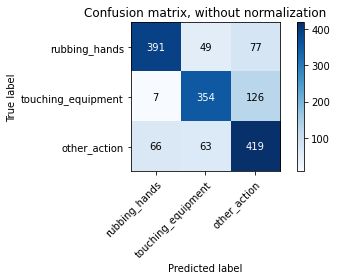

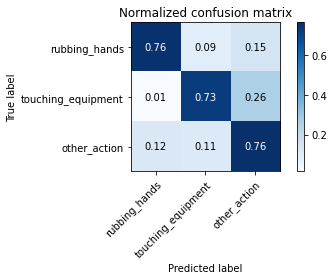

In [22]:
class_names = dataset['test'].classes
np.set_printoptions(precision=len(class_names))
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[391  49  77]
 [  7 354 126]
 [ 66  63 419]]
Normalized confusion matrix
[[0.756 0.095 0.149]
 [0.014 0.727 0.259]
 [0.12  0.115 0.765]]


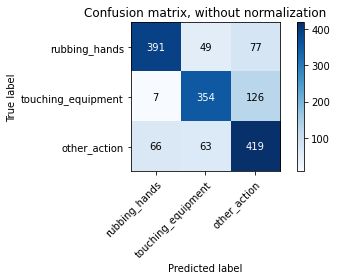

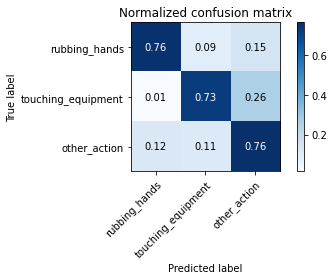

In [23]:
class_names = dataset['test'].classes
np.set_printoptions(precision=len(class_names))
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[379  52  86]
 [  9 360 118]
 [ 70  56 422]]
Normalized confusion matrix
[[0.73 0.1  0.17]
 [0.02 0.74 0.24]
 [0.13 0.1  0.77]]


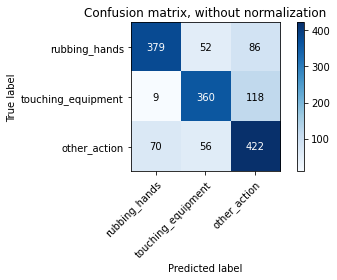

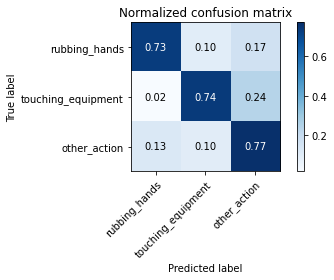

In [24]:
class_names = dataset['test'].classes
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, y_pred_rgb, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rgb, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[257 197  63]
 [ 27 306 154]
 [145 178 225]]
Normalized confusion matrix
[[0.5  0.38 0.12]
 [0.06 0.63 0.32]
 [0.26 0.32 0.41]]


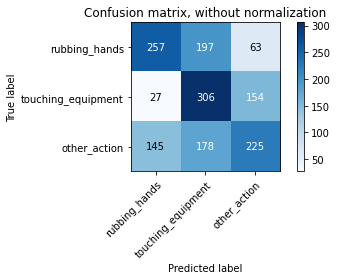

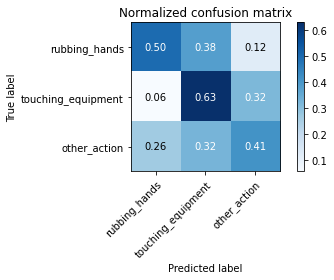

In [25]:
class_names = dataset['test'].classes
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, y_pred_flow, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_flow, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [36]:
num_per_class = dataloaders[phase].dataset._num_clips_per_class()
classes = dataloaders[phase].dataset.classes
total_num = sum([num_per_class[key] for key in num_per_class])
weight_per_class = {cls: 1-(num_per_class[cls]/total_num) for cls in classes}
weight_per_class = torch.tensor([weight_per_class[cls] for cls in classes]).to(device)

In [37]:
weight_per_class

tensor([0.6941, 0.6414, 0.6645], device='cuda:0')